In [1]:
!python3 -m venv new_env
!source new_env/bin/activate
%pip install numpy==1.26
%pip install --upgrade scanpy
%pip install igraph
%pip install openpyxl
%pip install leidenalg
%pip install hdf5plugin


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is a

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
from tqdm import tqdm
import hdf5plugin
# Set random seed for reproducibility
np.random.seed(42)
meta_data = pd.read_excel("../data/sea-ad_cohort_donor_metadata_072524.xlsx")
selected_samples = meta_data["Donor ID"][meta_data["Last CASI Score"] != np.nan]
print(f'{len(selected_samples)} donors remain.')
# Directory containing .h5ad files (update this path)
data_dir = "../data"
data_file = os.path.join(data_dir,"combined_corrected.h5ad")

84 donors remain.


In [3]:

def print_hdf5_item(name, obj):
    """Prints the name and type of HDF5 items."""
    print(name)
    if isinstance(obj, h5py.Dataset):
        print("    Dataset:", obj.shape, obj.dtype)
    elif isinstance(obj, h5py.Group):
        print("    Group")
    for key, val in obj.attrs.items():
        print(f"    Attribute: {key} = {val}")
# examine the datafiles
try:
    with h5py.File(data_file, 'r') as f:
        f.visititems(print_hdf5_item)
except FileNotFoundError:
    print(f"Error: File '{data_file}' not found.")
except OSError as e:
    print(f"OSError: {e}")
# adata = sc.read_h5ad(data_file) 

X
    Dataset: (1240908, 2000) float32
    Attribute: encoding-type = array
    Attribute: encoding-version = 0.2.0
layers
    Group
    Attribute: encoding-type = dict
    Attribute: encoding-version = 0.1.0
layers/UMIs
    Group
    Attribute: encoding-type = csr_matrix
    Attribute: encoding-version = 0.1.0
    Attribute: shape = [1240908    2000]
layers/UMIs/data
    Dataset: (1770713711,) float32
layers/UMIs/indices
    Dataset: (1770713711,) int32
layers/UMIs/indptr
    Dataset: (1240909,) int32
obs
    Group
    Attribute: _index = exp_component_name
    Attribute: column-order = ['sample_id' 'Neurotypical reference' 'Donor ID' 'Organism' 'Brain Region'
 'Sex' 'Gender' 'Age at Death' 'Race (choice=White)'
 'Race (choice=Black/ African American)' 'Race (choice=Asian)'
 'Race (choice=American Indian/ Alaska Native)'
 'Race (choice=Native Hawaiian or Pacific Islander)'
 'Race (choice=Unknown or unreported)' 'Race (choice=Other)'
 'specify other race' 'Hispanic/Latino' 'Highest lev

In [4]:
import scanpy as sc
import numpy as np
from tqdm import tqdm


def process_combined_dataset(combined_file_path, meta_data):
    print("Loading combined dataset...")
    adata = sc.read_h5ad(combined_file_path)
    
    # Extract unique donor IDs from the combined dataset
    donor_ids = adata.obs['Donor ID'].unique()
    print(f"Found {len(donor_ids)} unique donors in the dataset")
    
    # Categorize donors based on cognitive status
    dementia_donors = []
    no_dementia_donors = []
    young_donors = []
    
    for donor_id in tqdm(donor_ids, desc="Categorizing donors"):
        # Get cognitive status for this donor from metadata
        status = meta_data[meta_data["Donor ID"]==donor_id]["Cognitive Status"].tolist()
        
        if len(status) > 1:
            print(f"Error: Multiple cognitive status entries for donor {donor_id}!")
            continue
        if len(status) == 0:
            # Assuming donors with no cognitive status are young reference donors
            young_donors.append(donor_id)
        elif status[0] == "Dementia":
            dementia_donors.append(donor_id)
        elif status[0] == 'No dementia':
            no_dementia_donors.append(donor_id)
        else:
            print(f"Error: Unknown Cognitive Status '{status[0]}' for donor {donor_id}!")
            continue
    
    print(f"Dementia: {len(dementia_donors)}, No dementia: {len(no_dementia_donors)}, Young: {len(young_donors)}")
    
    # Sample donors according to the specified ratio for training set
    sample_ratio = 0.8
    n_donors = {
        'Dementia': int(sample_ratio * len(dementia_donors)), 
        'No dementia': int(sample_ratio * len(no_dementia_donors)), 
        'young': len(young_donors)  # Use all young donors
    }
    
    # Randomly select donors for training set
    selected_dementia = np.random.choice(dementia_donors, min(n_donors['Dementia'], len(dementia_donors)), replace=False).tolist()
    selected_no_dementia = np.random.choice(no_dementia_donors, min(n_donors['No dementia'], len(no_dementia_donors)), replace=False).tolist()
    selected_young = np.random.choice(young_donors, min(n_donors['young'], len(young_donors)), replace=False).tolist()
    
    selected_donors = selected_dementia + selected_no_dementia + selected_young
    print(f"Selected {len(selected_donors)} donors for training set")
    
    # Create testing set with remaining donors
    remaining_dementia = [d for d in dementia_donors if d not in selected_dementia]
    remaining_no_dementia = [d for d in no_dementia_donors if d not in selected_no_dementia]
    remaining_young = [d for d in young_donors if d not in selected_young]  # This should be empty if all young donors are used
    
    remaining_donors = remaining_dementia + remaining_no_dementia + remaining_young
    print(f"Remaining {len(remaining_donors)} donors for test set")
    
    # Instead of creating copies, we'll just return the indices for training and test sets
    is_training = adata.obs['Donor ID'].isin(selected_donors)
    training_indices = np.where(is_training)[0]
    test_indices = np.where(~is_training)[0]
    
    print(f"Created training indices with length: {len(training_indices)}")
    print(f"Created test indices with length: {len(test_indices)}")
    
    # Create a view instead of a copy for the training set
    training_set = adata[training_indices]
    test_set = adata[test_indices]
    
    print(f"Created training set with shape: {training_set.shape}")
    print(f"Created test set with shape: {test_set.shape}")
    
    donor_groups = {
        'dementia': {
            'all': dementia_donors,
            'training': selected_dementia,
            'testing': remaining_dementia
        },
        'no_dementia': {
            'all': no_dementia_donors,
            'training': selected_no_dementia,
            'testing': remaining_no_dementia
        },
        'young': {
            'all': young_donors,
            'training': selected_young,
            'testing': remaining_young
        },
        'indices': {
            'training': training_indices,
            'testing': test_indices
        }
    }
    
    return training_set, test_set, donor_groups

# Example usage
# combined_file_path = "path/to/combined_data.h5ad"
# meta_data = pd.read_csv("path/to/metadata.csv")  # Make sure to define or import meta_data
training_set, test_set, donor_groups = process_combined_dataset(data_file, meta_data)

Loading combined dataset...
Found 84 unique donors in the dataset


Categorizing donors: 100%|██████████| 84/84 [00:00<00:00, 6651.34it/s]

Dementia: 42, No dementia: 42, Young: 0
Selected 66 donors for training set
Remaining 18 donors for test set
Created training indices with length: 1004528
Created test indices with length: 236380


Created training set with shape: (1004528, 2000)
Created test set with shape: (236380, 2000)


In [5]:
import scanpy as sc
import numpy as np
import gc
from scanpy import logging
import warnings

def simulate_cluster_means(training_set, n_samples_per_donor_id, n_simulations, resolution=1.0, random_state=42):
    """
    Perform multiple simulations of sampling cells, clustering, and calculating cluster means.
    
    Parameters:
    -----------
    training_set : AnnData
        The training dataset containing cells from different donors
    n_samples_per_donor_id : int
        Number of cells to sample from each donor
    n_simulations : int
        Number of simulations to run
    resolution : float, default=1.0
        Resolution parameter for Leiden clustering
    random_state : int, default=42
        Random seed for reproducibility
    
    Returns:
    --------
    all_cluster_means : list
        List of cluster means for each simulation
        Each element is a dictionary with cluster ID as key and mean expression as value
    simulation_results : list
        List of dictionaries containing detailed results for each simulation
    """
    print(f"Starting {n_simulations} simulations with {n_samples_per_donor_id} samples per donor_id")
    
    # Get unique donor ids
    donor_ids = training_set.obs['Donor ID'].unique().tolist()
    print(f"Found {len(donor_ids)} unique donor ID")
    
    # Store all cluster means from all simulations
    all_cluster_means = []
    simulation_results = []
    
    for sim in range(n_simulations):
        np.random.seed(random_state + sim)  # Different seed for each simulation
        
        # Sample cells from each donor
        sampled_indices = []
        for donor_id in donor_ids:
            # Get indices of cells with this donor
            sample_indices = np.where(training_set.obs['Donor ID'] == donor_id)[0]
            
            # Sample from this group
            if len(sample_indices) > n_samples_per_donor_id:
                # If enough cells, sample without replacement
                selected_indices = np.random.choice(sample_indices, n_samples_per_donor_id, replace=False)
            else:
                # If not enough cells, sample with replacement to reach target count
                selected_indices = np.random.choice(sample_indices, n_samples_per_donor_id, replace=True)
                
            sampled_indices.extend(selected_indices)
        
        # Create a view (not a copy) of the AnnData object with the sampled cells
        adata_sample = training_set[sampled_indices]
        
        # PCA - necessary for clustering
        sc.tl.pca(adata_sample)
        
        # Compute neighborhood graph
        sc.pp.neighbors(adata_sample)
        
        # Run Leiden clustering
        sc.tl.leiden(adata_sample, resolution=resolution, random_state=random_state+sim, flavor="igraph", n_iterations=2, directed=False)
        
        # Calculate cluster means efficiently
        clusters = adata_sample.obs['leiden'].unique()
        cluster_means = []
        
        for cluster in clusters:
            # Get cells in this cluster using boolean indexing
            cluster_mask = adata_sample.obs['leiden'] == cluster
            cluster_cells = adata_sample[cluster_mask]
            
            # Calculate mean expression efficiently for sparse matrices
            if hasattr(cluster_cells.X, "toarray"):
                # For sparse matrices, compute mean without full conversion to dense
                mean_expression = np.array(cluster_cells.X.mean(axis=0)).flatten()
            else:
                mean_expression = np.mean(cluster_cells.X, axis=0)
                
                # Ensure it's a 1D array
                if mean_expression.ndim > 1:
                    mean_expression = mean_expression.flatten()
                    
            cluster_means.append(mean_expression)
        
        # Store results - only store the means, not the full data
        all_cluster_means.extend(cluster_means)
        
        # Store minimal information for this simulation to save memory
        simulation_info = {
            'simulation_id': sim,
            'optimal_k': len(clusters),
            'clusters': list(clusters),
            'cluster_sizes': {cluster: np.sum(adata_sample.obs['leiden'] == cluster) for cluster in clusters},
            # Don't store indices or full means again to save memory
        }
        
        simulation_results.append(simulation_info)
        
        print(f"Simulation {sim+1}/{n_simulations} complete: {len(clusters)} clusters identified")
        
        # Force garbage collection to free memory after each simulation
        gc.collect()
    
    print(f"All {n_simulations} simulations completed")
    
    return all_cluster_means, simulation_results

# Example usage:
warnings.filterwarnings("ignore", category=UserWarning, module="scanpy")
n_samples_per_donor_id = 3000  # Sample cells from each donor
n_simulations = 10  # Run 10 simulations
cluster_means, simulation_results = simulate_cluster_means(training_set, n_samples_per_donor_id, n_simulations)

Starting 10 simulations with 3000 samples per donor_id
Found 66 unique donor ID


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Simulation 1/10 complete: 37 clusters identified
Simulation 2/10 complete: 37 clusters identified
Simulation 3/10 complete: 37 clusters identified
Simulation 4/10 complete: 37 clusters identified
Simulation 5/10 complete: 39 clusters identified
Simulation 6/10 complete: 37 clusters identified
Simulation 7/10 complete: 39 clusters identified
Simulation 8/10 complete: 35 clusters identified
Simulation 9/10 complete: 36 clusters identified
Simulation 10/10 complete: 36 clusters identified
All 10 simulations completed


In [6]:
# Convert cluster means to a numpy array (leave out cluster labels)
cluster_means_array = np.array(cluster_means)
print(cluster_means_array.shape)

(370, 2000)


Processing: 100%|██████████| 40/40 [00:13<00:00,  3.00it/s]


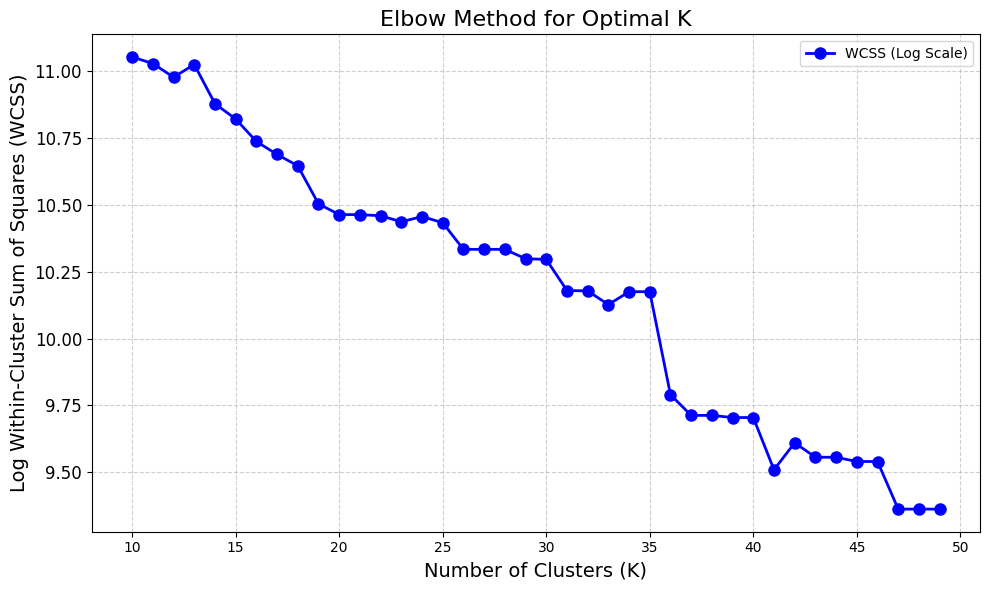

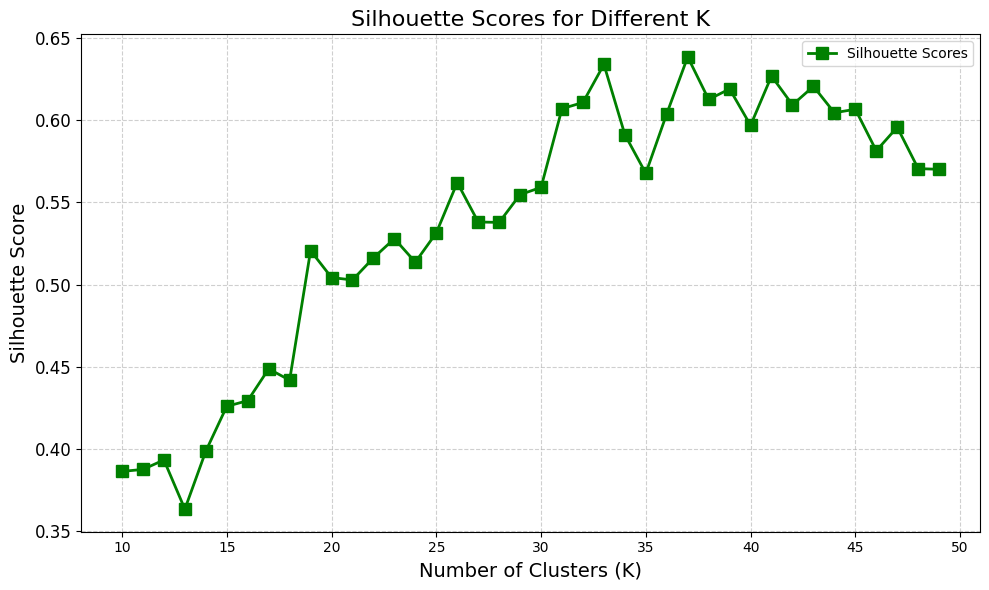

In [7]:

## cluster of cluster_mean
import importlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import my_kmeans.kmeans as kmeans
importlib.reload(kmeans)
from sklearn.metrics import silhouette_score
# ------------------------------------------
# 1. Compute WCSS for different K values
# ------------------------------------------
silhouette_scores = []
wcss_values = []
K_range = range(10, 50)  # Test cluster numbers from 1 to 10
for k in tqdm(K_range,desc = "Processing"):
    _, wcss, labels = kmeans.k_means(np.array(cluster_means_array.T), k, max_iterations= None, random_state=42)
    wcss_values.append(wcss)  # Inertia is the WCSS (sum of squared distances)
    score = silhouette_score(cluster_means_array, labels)
    silhouette_scores.append(score)

# ------------------------------------------
# 2. Plot WCSS vs. Number of Clusters (Elbow Method)
# ------------------------------------------
plt.figure(figsize=(10, 6))  # Increase figure size for clarity
plt.plot(K_range, np.log(wcss_values), marker='o', linestyle='-', color='b', markersize=8, linewidth=2, label='WCSS (Log Scale)') 
plt.xlabel("Number of Clusters (K)", fontsize=14)
plt.ylabel("Log Within-Cluster Sum of Squares (WCSS)", fontsize=14)
plt.title("Elbow Method for Optimal K", fontsize=16)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)  # Add grid for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# ------------------------------------------
# Plotting the silhouette scores
# ------------------------------------------
plt.figure(figsize=(10, 6))  # Increase figure size for clarity
plt.plot(K_range, silhouette_scores, marker='s', linestyle='-', color='g', markersize=8, linewidth=2, label='Silhouette Scores')
plt.title('Silhouette Scores for Different K', fontsize=16)
plt.xlabel('Number of Clusters (K)', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)  # Add grid for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [8]:
optimal_k = np.argmax(np.array(silhouette_scores)) + K_range[0]
print(f"Set k = {optimal_k}.")
overall_cluster_means, _, _ = kmeans.k_means(np.array(cluster_means_array.T), optimal_k, max_iterations= None, random_state=42)
# Assuming overall_cluster_means is your 2000x28 NumPy array
# (2000 features, 28 clusters)
def create_cluster_means_dict(overall_cluster_means, feature_names=None):
    """
    Convert a cluster means matrix to a dictionary format required by label_dataset_with_clusters.
    
    Parameters:
    -----------
    overall_cluster_means : numpy.ndarray
        2D array of shape (n_features, n_clusters) or (n_clusters, n_features)
        Contains the mean expression values for each cluster
    feature_names : list, optional
        List of feature names. If None, feature indices will be used.
        
    Returns:
    --------
    cluster_means_dict : dict
        Dictionary with cluster IDs as keys and mean expression vectors as values
    """
    # Determine the shape and orientation of the matrix
    shape = overall_cluster_means.shape
    means_array = overall_cluster_means.T
    n_clusters = shape[1]

    
    # Create the dictionary
    cluster_means_dict = {}
    for i in range(n_clusters):
        # Use string keys to match the expected format
        cluster_id = str(i)
        cluster_means_dict[cluster_id] = means_array[i]
    
    return cluster_means_dict

# Convert overall_cluster_means to the dictionary format
cluster_means_dict = create_cluster_means_dict(overall_cluster_means)



Set k = 37.


In [9]:
from scipy.spatial.distance import cdist
import scanpy as sc
import numpy as np
import pandas as pd
import gc
from tqdm import tqdm

def label_dataset_with_clusters(dataset, cluster_means_dict, output_path=None):
    """
    Label a dataset based on similarity to pre-calculated cluster means.
    
    Parameters:
    -----------
    dataset : AnnData or str
        The AnnData object to label or path to h5ad file.
    cluster_means_dict : dict
        Dictionary with cluster IDs as keys and mean expression vectors as values.
    output_path : str, optional
        Path to save the resulting DataFrame. If None, only returns the DataFrame.
        
    Returns:
    --------
    patient_cluster_expr_df : pandas.DataFrame
        DataFrame containing sample IDs, cluster assignments, and mean expression values.
    """
    print("Starting dataset labeling based on cluster similarity...")
    
    # Convert cluster means dictionary to array for faster distance calculation
    cluster_ids = list(cluster_means_dict.keys())
    cluster_means_array = np.array([cluster_means_dict[cluster_id] for cluster_id in cluster_ids])
    
    # Initialize DataFrame and dictionary for cognitive status
    patient_cluster_expr_df = pd.DataFrame()
    sample_status = {}
    
    # Load the dataset if a path is provided
    if isinstance(dataset, str):
        print(f"Loading dataset from {dataset}")
        adata = sc.read_h5ad(dataset)
    else:
        adata = dataset
        
    # Get unique sample IDs
    if 'Donor ID' not in adata.obs.columns:
        print("Warning: 'Donor ID' column not found. Using first available sample ID for all cells.")
        # Extract a sample ID if available in the file name or metadata
        if hasattr(adata, 'filename') and adata.filename is not None:
            donor_id = adata.filename.split('/')[-1].split('.')[0]
        else:
            donor_id = "unknown_donor"
        adata.obs['Donor ID'] = donor_id
    
    donor_ids = adata.obs['Donor ID'].unique()
    print(f"Found {len(donor_ids)} unique Donor IDs")
    
    # Process each sample separately to save memory
    for donor_id in tqdm(donor_ids, desc="Processing samples"):
        # Subset to the current sample
        sample_mask = adata.obs['Donor ID'] == donor_id
        sample_data = adata[sample_mask].copy()  # Explicitly create a copy to avoid ImplicitModificationWarning
        
        # Store cognitive status if available
        if 'Cognitive Status' in sample_data.obs.columns:
            sample_status[donor_id] = sample_data.obs['Cognitive Status'].iloc[0]
        
        # Convert sparse matrix to dense for distance calculation if needed
        X = sample_data.X
        if hasattr(X, "toarray"):
            # For larger matrices, process in batches to avoid memory issues
            batch_size = 1000  # Adjust based on available memory
            n_cells = X.shape[0]
            sample_data.obs['leiden'] = np.zeros(n_cells, dtype=str)  # Change to string type for cluster IDs
            
            for batch_start in range(0, n_cells, batch_size):
                batch_end = min(batch_start + batch_size, n_cells)
                batch_X = X[batch_start:batch_end].toarray()
                
                # Calculate distances and assign clusters
                distances = cdist(batch_X, cluster_means_array, metric='euclidean')
                cluster_assignments = np.argmin(distances, axis=1)
                
                # Convert numeric indices to original cluster IDs
                sample_data.obs.iloc[batch_start:batch_end, 
                                    sample_data.obs.columns.get_loc('leiden')] = [
                    cluster_ids[idx] for idx in cluster_assignments
                ]
                
                # Free memory
                del batch_X, distances, cluster_assignments
                gc.collect()
        else:
            # For small or already dense matrices
            distances = cdist(X, cluster_means_array, metric='euclidean')
            cluster_assignments = np.argmin(distances, axis=1)
            sample_data.obs['leiden'] = [cluster_ids[idx] for idx in cluster_assignments]
        
        # Compute and store mean expression per cluster
        rows = []
        for cluster in sample_data.obs['leiden'].unique():
            cluster_cells = sample_data[sample_data.obs['leiden'] == cluster]
            
            # Efficiently compute mean expression
            if hasattr(cluster_cells.X, "toarray"):
                mean_expr = np.array(cluster_cells.X.mean(axis=0)).flatten()
            else:
                mean_expr = np.mean(cluster_cells.X, axis=0)
                if mean_expr.ndim > 1:
                    mean_expr = mean_expr.flatten()
            
            # Create a dictionary for the current sample and cluster
            row_dict = {'Donor ID': donor_id, 'cluster': cluster}
            
            # Store the mean expression vector as a column
            row_dict['mean_expression'] = mean_expr.tolist()
            
            # Count cells in this cluster for this donor
            row_dict['cell_count'] = len(cluster_cells)
            
            # Add percent of cells in this cluster for this donor
            row_dict['percent_cells'] = (len(cluster_cells) / len(sample_data)) * 100
            
            rows.append(row_dict)
        
        # Append the results for this sample to the main DataFrame
        sample_df = pd.DataFrame(rows)
        patient_cluster_expr_df = pd.concat([patient_cluster_expr_df, sample_df], ignore_index=True)
        
        # Clear memory
        del sample_data, rows, sample_df
        gc.collect()
    
    # Add cognitive status to the final DataFrame if available
    if sample_status:
        patient_cluster_expr_df['Cognitive Status'] = patient_cluster_expr_df['Donor ID'].map(sample_status)
    
    # Save results if output path is provided
    if output_path:
        print(f"Saving results to {output_path}")
        patient_cluster_expr_df.to_csv(output_path, index=False)
        print(f"Saved to '{output_path}'")
    
    return patient_cluster_expr_df

# Example usage:
train_cluster_expr_df = label_dataset_with_clusters(training_set, cluster_means_dict, "training_cluster_expression.csv")
test_cluster_expr_df = label_dataset_with_clusters(test_set, cluster_means_dict, "test_cluster_expression.csv")

Starting dataset labeling based on cluster similarity...
Found 66 unique Donor IDs


Processing samples: 100%|██████████| 66/66 [02:19<00:00,  2.11s/it]


Saving results to training_cluster_expression.csv
Saved to 'training_cluster_expression.csv'
Starting dataset labeling based on cluster similarity...
Found 18 unique Donor IDs


Processing samples: 100%|██████████| 18/18 [00:32<00:00,  1.81s/it]


Saving results to test_cluster_expression.csv
Saved to 'test_cluster_expression.csv'


Analyzing cluster distribution...

Cluster Distribution Summary:
Total cells: 1240908
Number of clusters: 37

Top 5 clusters by cell count:
cluster  cell_count  percent_of_total  number_of_donors  avg_cells_per_donor
     19      162293         13.078568                84          1932.059524
      7      105753          8.522227                84          1258.964286
     36      102957          8.296908                84          1225.678571
     17       92646          7.465985                84          1102.928571
      0       73110          5.891654                83           880.843373


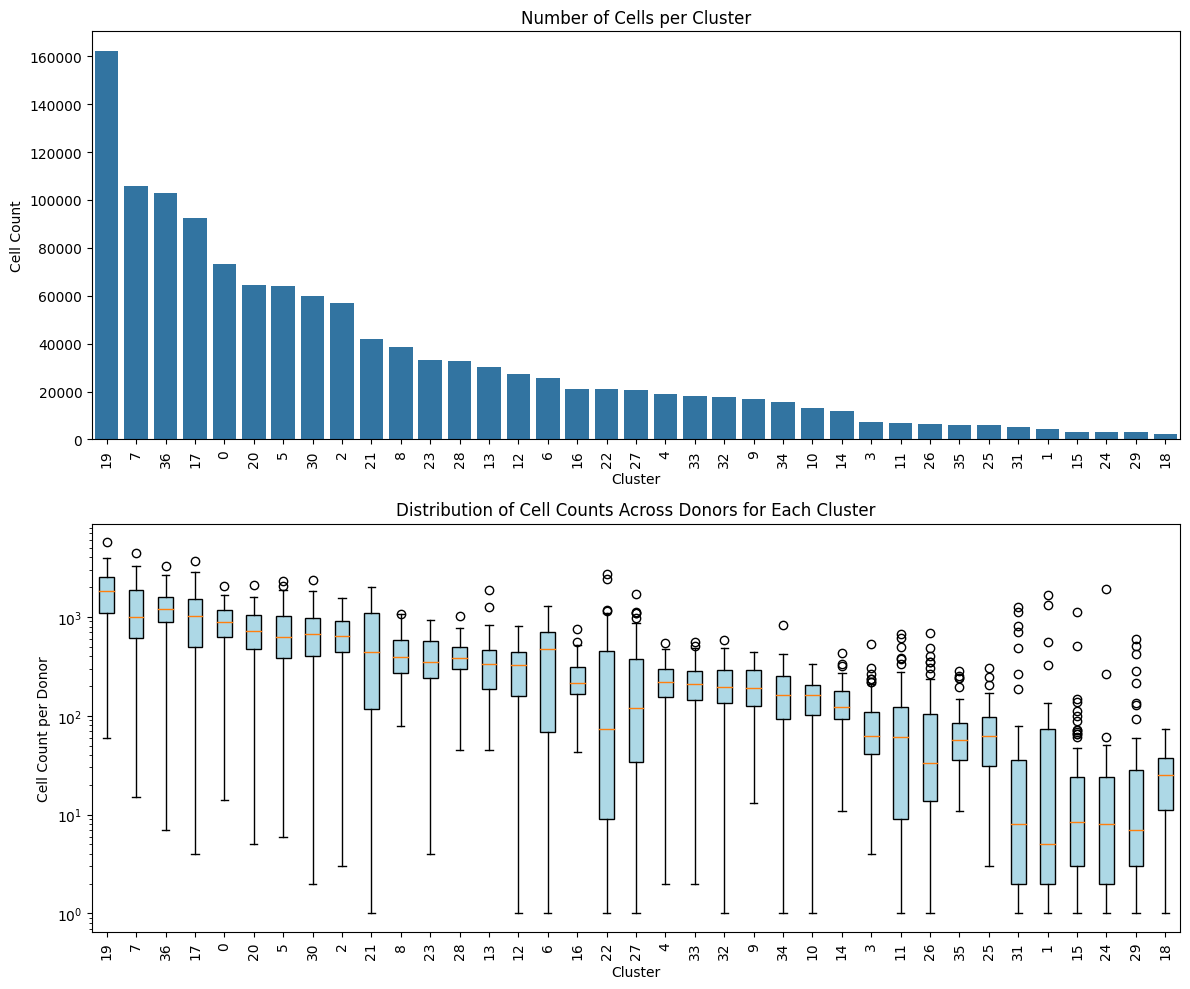


Analyzing clusters by cognitive status...

Cluster distribution by cognitive status:
Cognitive Status  Dementia  No dementia  Dementia %  No dementia %
cluster                                                           
0                    30157        42953    5.617837       6.100412
1                     1753         2548    0.326560       0.361880
10                    5675         7280    1.057175       1.033944
11                    3330         3484    0.620334       0.494816
12                   10145        17285    1.889875       2.454907
13                   13107        17300    2.441655       2.457037
14                    5896         5854    1.098344       0.831416
15                    2798          430    0.521229       0.061071
16                   10499        10661    1.955820       1.514132
17                   33278        59368    6.199237       8.431757


<Figure size 1200x600 with 0 Axes>

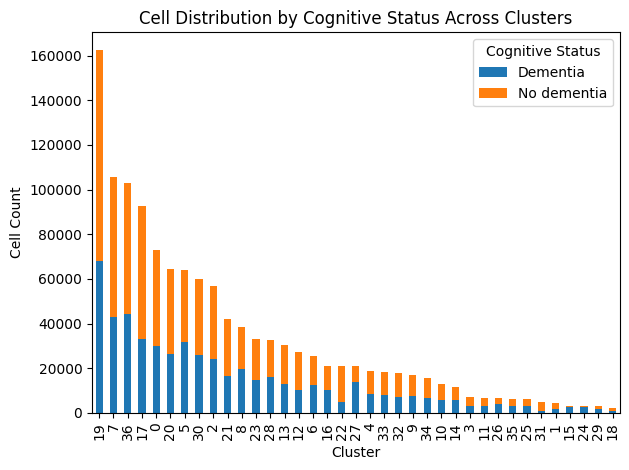


Dementia vs. No Dementia Comparison:
  cluster  Dementia  No_dementia  Dementia_to_No_dementia_ratio
0      24      2740          385                       7.116883
1      15      2798          430                       6.506977
2      27     13754         7102                       1.936638
3      26      4145         2480                       1.671371
4      29      1701         1252                       1.358626
5      35      3305         2806                       1.177833
6      25      3110         2957                       1.051742
7       8     19735        18908                       1.043738
8      14      5896         5854                       1.007175
9      16     10499        10661                       0.984804


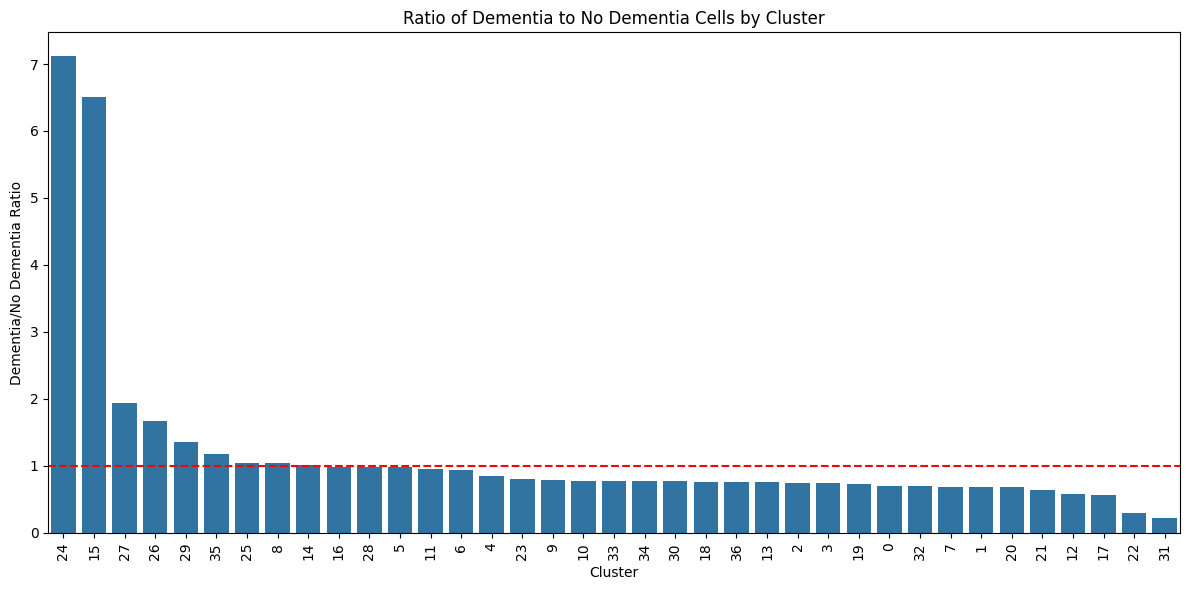

<Figure size 1000x800 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def analyze_cluster_distribution(cluster_df):
    """
    Analyze and visualize the distribution of cells across clusters with comparison
    between dementia and no dementia groups.
    
    Parameters:
    -----------
    cluster_df : pandas.DataFrame
        DataFrame containing cluster assignments from label_dataset_with_clusters
        
    Returns:
    --------
    summary_df : pandas.DataFrame
        Summary statistics about cluster distributions
    """
    print("Analyzing cluster distribution...")
    
    # Ensure required columns exist
    required_columns = ['Donor ID', 'cluster', 'cell_count']
    for col in required_columns:
        if col not in cluster_df.columns:
            raise ValueError(f"Required column '{col}' not found in the DataFrame")
    
    # Get total counts per cluster
    cluster_counts = cluster_df.groupby('cluster')['cell_count'].sum().reset_index()
    cluster_counts = cluster_counts.sort_values('cell_count', ascending=False)
    
    # Calculate percentage of total cells
    total_cells = cluster_counts['cell_count'].sum()
    cluster_counts['percent_of_total'] = (cluster_counts['cell_count'] / total_cells) * 100
    
    # Count donors per cluster
    donors_per_cluster = cluster_df.groupby('cluster')['Donor ID'].nunique().reset_index()
    donors_per_cluster.columns = ['cluster', 'number_of_donors']
    
    # Merge counts and donors
    summary_df = pd.merge(cluster_counts, donors_per_cluster, on='cluster')
    
    # Calculate average cells per donor for each cluster
    summary_df['avg_cells_per_donor'] = summary_df['cell_count'] / summary_df['number_of_donors']
    
    # Print summary
    print("\nCluster Distribution Summary:")
    print(f"Total cells: {total_cells}")
    print(f"Number of clusters: {len(summary_df)}")
    print("\nTop 5 clusters by cell count:")
    print(summary_df.head(5).to_string(index=False))
    
    # Create visualizations
    plt.figure(figsize=(12, 10))
    
    # Plot 1: Bar chart of cell counts by cluster
    plt.subplot(2, 1, 1)
    sns.barplot(x='cluster', y='cell_count', data=summary_df, order=summary_df.sort_values('cell_count', ascending=False)['cluster'])
    plt.title('Number of Cells per Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Cell Count')
    plt.xticks(rotation=90)
    
    # Plot 2: Distribution of cell counts across donors for each cluster
    plt.subplot(2, 1, 2)
    
    # Create a box plot showing distribution of cells per donor for each cluster
    cluster_donor_counts = cluster_df.pivot_table(
        index='cluster', 
        columns='Donor ID', 
        values='cell_count', 
        aggfunc='sum',
        fill_value=0
    )
    
    # Reshape for box plot
    cluster_donor_data = []
    for cluster in summary_df.sort_values('cell_count', ascending=False)['cluster']:
        if cluster in cluster_donor_counts.index:
            values = cluster_donor_counts.loc[cluster].values
            values = values[values > 0]  # Only include donors that have cells in this cluster
            cluster_donor_data.append({
                'cluster': cluster,
                'values': values
            })
    
    # Create the box plot
    box_positions = np.arange(len(cluster_donor_data))
    
    plt.boxplot([item['values'] for item in cluster_donor_data], 
                positions=box_positions, 
                patch_artist=True,
                boxprops=dict(facecolor='lightblue'))
    
    plt.xticks(box_positions, [item['cluster'] for item in cluster_donor_data], rotation=90)
    plt.title('Distribution of Cell Counts Across Donors for Each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Cell Count per Donor')
    plt.yscale('log')  # Log scale often helps visualize distributions with wide ranges
    
    plt.tight_layout()
    plt.savefig('cluster_distribution.png', dpi=300)
    plt.show()
    
    # Additional analysis based on cognitive status if available
    if 'Cognitive Status' in cluster_df.columns:
        print("\nAnalyzing clusters by cognitive status...")
        
        # Ensure we have dementia status data to work with
        status_counts = cluster_df.groupby(['cluster', 'Cognitive Status'])['cell_count'].sum().reset_index()
        
        # Check if we have both dementia and no dementia statuses
        statuses = status_counts['Cognitive Status'].unique()
        has_dementia_comparison = ('Dementia' in statuses and 'No dementia' in statuses)
        
        if len(statuses) > 0:
            # Create pivot table
            status_pivot = status_counts.pivot_table(
                index='cluster',
                columns='Cognitive Status',
                values='cell_count',
                fill_value=0
            )
            
            # Calculate percentage within each status
            for status in status_pivot.columns:
                status_total = status_pivot[status].sum()
                status_pivot[f'{status} %'] = (status_pivot[status] / status_total) * 100
            
            print("\nCluster distribution by cognitive status:")
            print(status_pivot.head(10))
            
            # Create a stacked bar chart
            plt.figure(figsize=(12, 6))
            
            # Get columns that aren't percentage columns
            non_pct_cols = [col for col in status_pivot.columns if not col.endswith('%')]
            if non_pct_cols:  # Make sure we have data columns
                status_pivot_plot = status_pivot[non_pct_cols].copy()
                
                # Sort by total cell count across all statuses
                row_sums = status_pivot_plot.sum(axis=1)
                status_pivot_plot = status_pivot_plot.loc[row_sums.sort_values(ascending=False).index]
                
                status_pivot_plot.plot(kind='bar', stacked=True)
                plt.title('Cell Distribution by Cognitive Status Across Clusters')
                plt.xlabel('Cluster')
                plt.ylabel('Cell Count')
                plt.xticks(rotation=90)
                plt.tight_layout()
                plt.savefig('cluster_by_cognitive_status.png', dpi=300)
                plt.show()
            
            # If we have both dementia and no dementia, create comparison plots
            if has_dementia_comparison:
                # Create comparison dataframe for dementia vs. no dementia
                comparison_df = pd.DataFrame({
                    'cluster': status_pivot.index,
                    'Dementia': status_pivot.get('Dementia', 0),
                    'No_dementia': status_pivot.get('No dementia', 0)
                })
                
                # Calculate ratio (Dementia / No dementia)
                comparison_df['Dementia_to_No_dementia_ratio'] = comparison_df['Dementia'] / comparison_df['No_dementia'].replace(0, np.nan)
                
                # Sort by ratio for visualization
                comparison_df = comparison_df.sort_values('Dementia_to_No_dementia_ratio', ascending=False).reset_index(drop=True)
                
                # Drop rows with NaN ratios (no 'No dementia' cells)
                comparison_df = comparison_df.dropna(subset=['Dementia_to_No_dementia_ratio'])
                
                # Print comparison summary
                print("\nDementia vs. No Dementia Comparison:")
                print(comparison_df.head(10))
                
                # Create ratio visualization
                plt.figure(figsize=(12, 6))
                sns.barplot(x='cluster', y='Dementia_to_No_dementia_ratio', data=comparison_df)
                plt.title('Ratio of Dementia to No Dementia Cells by Cluster')
                plt.xlabel('Cluster')
                plt.ylabel('Dementia/No Dementia Ratio')
                plt.xticks(rotation=90)
                plt.axhline(y=1, color='r', linestyle='--')  # Add reference line at ratio=1
                plt.tight_layout()
                plt.savefig('dementia_vs_no_dementia_ratio.png', dpi=300)
                plt.show()
                
                # Create enrichment heatmap - which clusters are enriched in which condition
                plt.figure(figsize=(10, 8))
                
                # Calculate percentages within each cognitive status
                enrichment_data = status_pivot.copy()
                
                # Calculate percentages
                dementia_total = enrichment_data.get('Dementia', 0).sum()
                no_dementia_total = enrichment_data.get('No dementia', 0).sum()
                
                if dementia_total > 0 and no_dementia_total > 0:
                    enrichment_data['Dementia_pct'] = enrichment_data.get('Dementia', 0) / dementia_total * 100
                    enrichment_data['No_dementia_pct'] = enrichment_data.get('No dementia', 0) / no_dementia_total * 100
                    
                    # Calculate log2 fold change
                    enrichment_data['log2FC'] = np.log2((enrichment_data['Dementia_pct'] + 0.1) / 
                                                        (enrichment_data['No_dementia_pct'] + 0.1))
                    
                    # Sort by log2FC
                    enrichment_data = enrichment_data.sort_values('log2FC', ascending=False)
                    
               
                    # Add enrichment data to summary_df
                    enrichment_info = enrichment_data[['Dementia_pct', 'No_dementia_pct', 'log2FC']]
                    summary_df = pd.merge(summary_df, enrichment_info, left_on='cluster', right_index=True, how='left')
    
    return summary_df

# Example usage:
patient_cluster_expr_df = pd.concat([train_cluster_expr_df, test_cluster_expr_df])
summary = analyze_cluster_distribution(patient_cluster_expr_df)

Computing cluster assignment errors...

Error statistics by cognitive status:
  Cognitive Status       mean       std       min        max
0         Dementia  11.885727  7.745874  0.266826  68.724776
1      No dementia  11.354449  8.267482  4.028108  69.728933


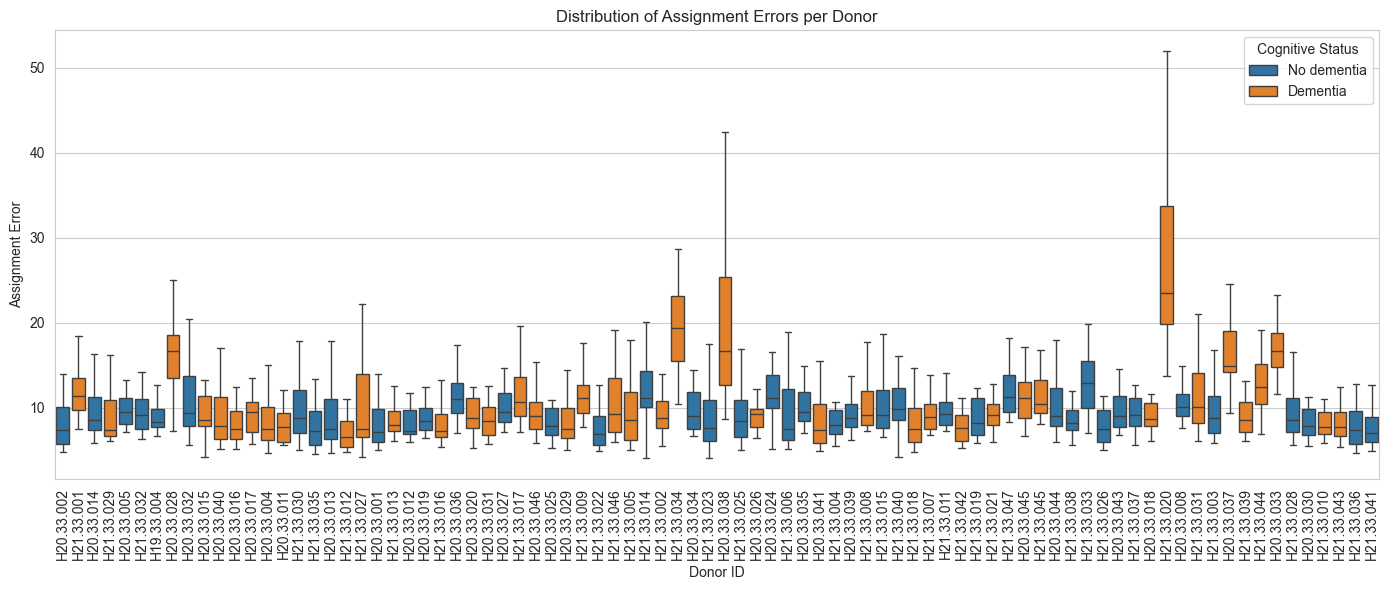

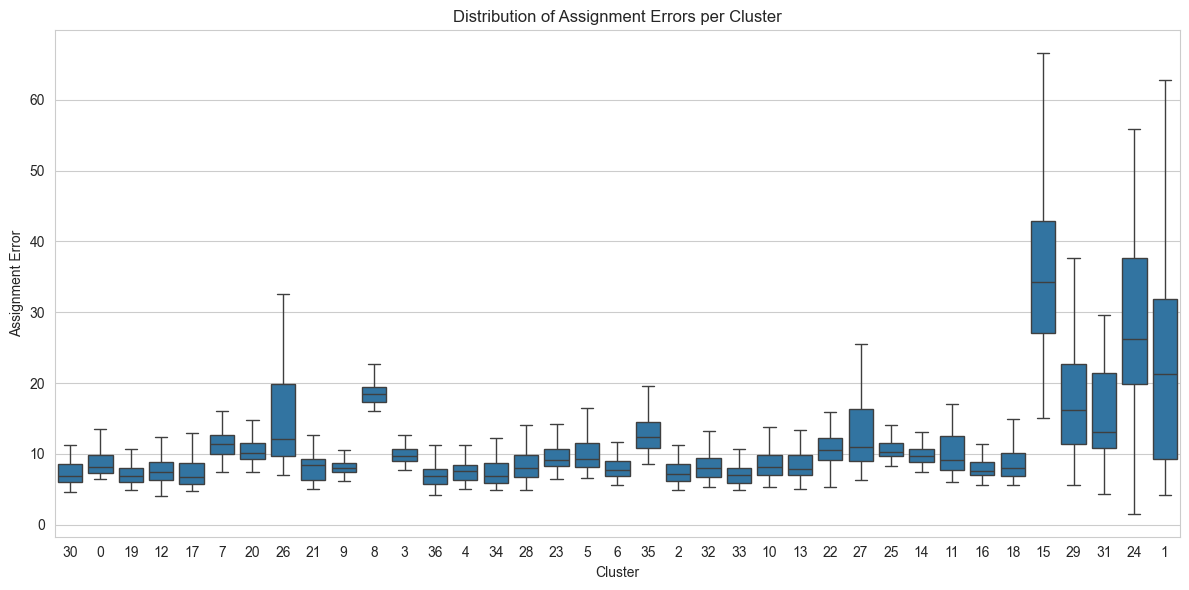

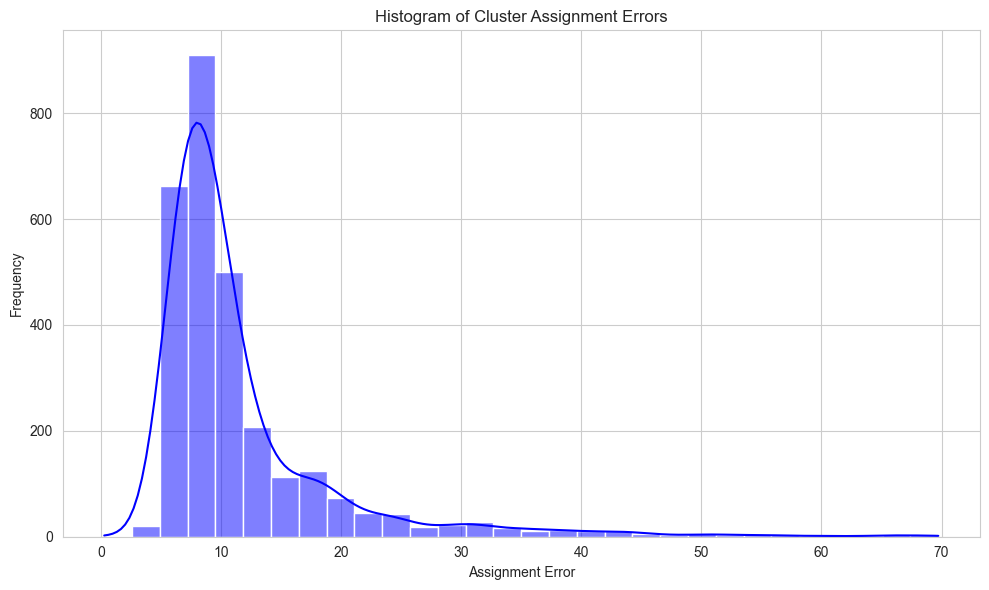

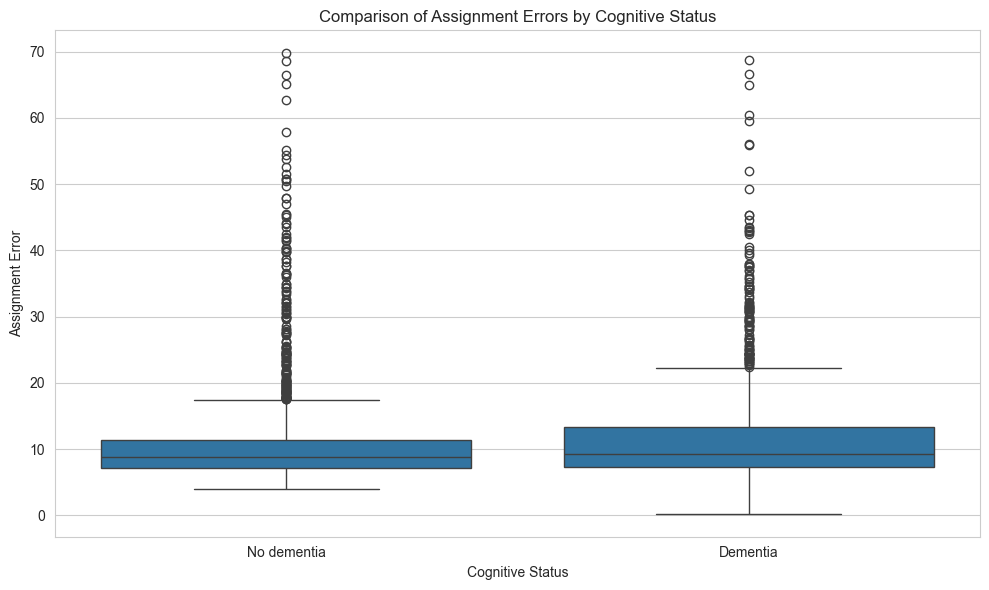


Cell-count weighted average error by cognitive status:
Cognitive Status
Dementia       8.614484
No dementia    8.318007
dtype: float64
Saved error data to 'cluster_assignment_errors.csv'
Saved error statistics per donor and cluster.
Saved error statistics per cognitive status.


In [11]:
def compute_assignment_errors(cluster_df, cluster_means_dict):
    """
    Compute and visualize assignment errors between samples and their assigned clusters.
    
    Parameters:
    -----------
    cluster_df : pandas.DataFrame
        DataFrame from label_dataset_with_clusters containing cluster assignments
    cluster_means_dict : dict
        Dictionary containing cluster means used for assignment
        
    Returns:
    --------
    error_df : pandas.DataFrame
        DataFrame containing error calculations for each sample-cluster pair
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.spatial.distance import cdist
    
    print("Computing cluster assignment errors...")
    
    # Convert cluster means dictionary to array
    cluster_ids = list(cluster_means_dict.keys())
    cluster_means_array = {cluster_id: cluster_means_dict[cluster_id] for cluster_id in cluster_ids}
    
    # Compute error for each sample-cluster pair
    errors = []
    
    # Iterate through each row in the cluster assignment dataframe
    for i, row in cluster_df.iterrows():
        # Get donor ID and cluster
        donor_id = row['Donor ID']
        cluster_id = row['cluster']
        
        # Get the mean expression for this donor-cluster pair
        if 'mean_expression' in row:
            # If stored as a list in a column
            sample_expr = np.array(row['mean_expression'])
        else:
            # If stored as individual columns
            # Get all columns except metadata
            metadata_cols = ['Donor ID', 'cluster', 'Cognitive Status', 'cell_count', 'percent_cells']
            expr_cols = [col for col in row.index if col not in metadata_cols]
            if expr_cols:
                sample_expr = row[expr_cols].values
            else:
                print(f"Warning: No expression data found for donor {donor_id}, cluster {cluster_id}")
                continue
        
        # Get the reference cluster mean
        cluster_mean = cluster_means_array[cluster_id]
        
        # Compute error as Euclidean distance to assigned cluster mean
        error = np.linalg.norm(sample_expr - cluster_mean)
        
        # Add to errors list
        errors.append({
            'Donor ID': donor_id, 
            'cluster': cluster_id, 
            'error': error,
            'cell_count': row.get('cell_count', 0)
        })
        
        # Add cognitive status if available
        if 'Cognitive Status' in row:
            errors[-1]['Cognitive Status'] = row['Cognitive Status']
    
    # Convert errors to DataFrame
    error_df = pd.DataFrame(errors)
    
    # Compute error statistics
    error_stats_donor = error_df.groupby('Donor ID')['error'].agg(['mean', 'std', 'min', 'max']).reset_index()
    error_stats_cluster = error_df.groupby('cluster')['error'].agg(['mean', 'std', 'min', 'max']).reset_index()
    
    # If we have cognitive status, compute stats by status
    if 'Cognitive Status' in error_df.columns:
        error_stats_status = error_df.groupby('Cognitive Status')['error'].agg(['mean', 'std', 'min', 'max']).reset_index()
        print("\nError statistics by cognitive status:")
        print(error_stats_status)
    
    # Visualize error distributions
    sns.set_style("whitegrid")
    
    # Boxplot of errors per donor - FIX: Create a more stable version
    plt.figure(figsize=(14, 6))
    
    # Instead of accessing the box artists directly, use a safer approach with color mapping
    if 'Cognitive Status' in error_df.columns:
        # Use hue parameter for cognitive status coloring
        ax = sns.boxplot(data=error_df, x='Donor ID', y='error', hue='Cognitive Status', showfliers=False)
        plt.legend(title="Cognitive Status")
    else:
        ax = sns.boxplot(data=error_df, x='Donor ID', y='error', showfliers=False)
    
    plt.xticks(rotation=90)
    plt.xlabel("Donor ID")
    plt.ylabel("Assignment Error")
    plt.title("Distribution of Assignment Errors per Donor")
    plt.tight_layout()
    plt.savefig('error_by_donor.png', dpi=300)
    plt.show()
    
    # Boxplot of errors per cluster
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=error_df, x='cluster', y='error', showfliers=False)
    plt.xlabel("Cluster")
    plt.ylabel("Assignment Error")
    plt.title("Distribution of Assignment Errors per Cluster")
    plt.tight_layout()
    plt.savefig('error_by_cluster.png', dpi=300)
    plt.show()
    
    # Histogram of error distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(error_df['error'], bins=30, kde=True, color='blue')
    plt.xlabel("Assignment Error")
    plt.ylabel("Frequency")
    plt.title("Histogram of Cluster Assignment Errors")
    plt.tight_layout()
    plt.savefig('error_histogram.png', dpi=300)
    plt.show()
    
    # If we have cognitive status, compare error distributions between statuses
    if 'Cognitive Status' in error_df.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=error_df, x='Cognitive Status', y='error')
        plt.xlabel("Cognitive Status")
        plt.ylabel("Assignment Error")
        plt.title("Comparison of Assignment Errors by Cognitive Status")
        plt.tight_layout()
        plt.savefig('error_by_status.png', dpi=300)
        plt.show()
        
        # Weighted error by cell count
        error_df['weighted_error'] = error_df['error'] * error_df['cell_count']
        weighted_error_sum = error_df.groupby('Cognitive Status')['weighted_error'].sum()
        total_cells = error_df.groupby('Cognitive Status')['cell_count'].sum()
        avg_weighted_error = weighted_error_sum / total_cells
        
        print("\nCell-count weighted average error by cognitive status:")
        print(avg_weighted_error)
    
    # Save results
    error_df.to_csv("cluster_assignment_errors.csv", index=False)
    print("Saved error data to 'cluster_assignment_errors.csv'")
    
    error_stats_donor.to_csv("error_stats_per_donor.csv", index=False)
    error_stats_cluster.to_csv("error_stats_per_cluster.csv", index=False)
    print("Saved error statistics per donor and cluster.")
    
    if 'Cognitive Status' in error_df.columns:
        error_stats_status.to_csv("error_stats_per_status.csv", index=False)
        print("Saved error statistics per cognitive status.")
    
    return error_df

# Example usage:
error_df = compute_assignment_errors(patient_cluster_expr_df, cluster_means_dict)

/var/folders/yk/2j5cfqyd7kj0kyn2bcjzg4lr0000gn/T/ipykernel_1626/4165623065.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score["Last CASI Score"] = score["Last CASI Score"].fillna(meta_data["Last CASI Score"].mean())


Cluster 30: Best alpha = 0.9103
Cluster 0: Best alpha = 1.8421
Cluster 19: Best alpha = 1.0481
Cluster 12: Best alpha = 1.8421
Cluster 17: Best alpha = 0.5964
Cluster 7: Best alpha = 1.0481
Cluster 20: Best alpha = 10.0000
Cluster 26: Best alpha = 1.5999
Cluster 21: Best alpha = 0.7906
Cluster 9: Best alpha = 10.0000
Cluster 8: Best alpha = 10.0000
Cluster 3: Best alpha = 2.4421
Cluster 36: Best alpha = 0.7906
Cluster 4: Best alpha = 1.5999
Cluster 34: Best alpha = 2.4421
Cluster 28: Best alpha = 10.0000
Cluster 23: Best alpha = 10.0000
Cluster 5: Best alpha = 3.2375
Cluster 6: Best alpha = 1.0481
Cluster 35: Best alpha = 10.0000
Cluster 2: Best alpha = 2.8118
Cluster 32: Best alpha = 3.2375
Cluster 33: Best alpha = 2.1210
Cluster 10: Best alpha = 1.8421
Cluster 13: Best alpha = 0.3907
Cluster 22: Best alpha = 0.2560
Cluster 27: Best alpha = 0.9103
Cluster 25: Best alpha = 2.1210
Cluster 14: Best alpha = 2.8118
Cluster 11: Best alpha = 10.0000
Cluster 16: Best alpha = 2.4421
Cluster 18

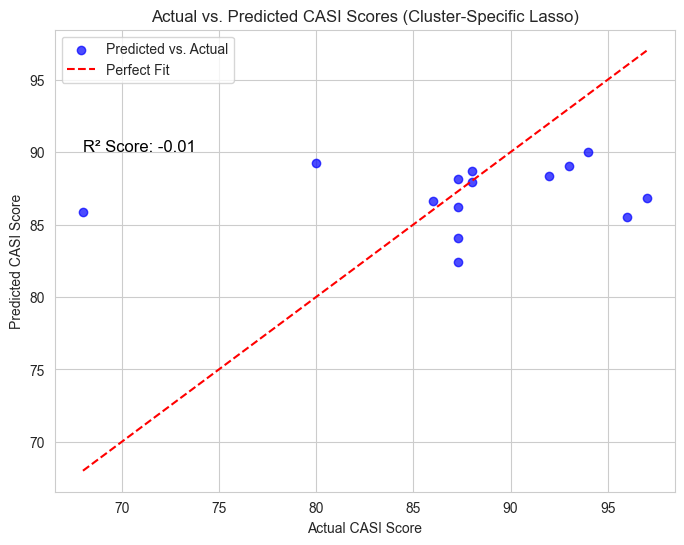

In [12]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast

# Function to process the new patient cluster dataframe format
def predict_casi_scores(score_df, patient_cluster_df):
    """
    Predicts CASI scores using cluster-specific Lasso models from the new format patient cluster data.
    
    Parameters:
    -----------
    score_df : DataFrame
        DataFrame with "Donor ID" and "Last CASI Score" columns
    patient_cluster_df : DataFrame
        DataFrame with columns: 'Donor ID', 'cluster', 'mean_expression', 'cell_count', 
        'percent_cells', 'Cognitive Status'
    
    Returns:
    --------
    r2 : float
        R² score on test set
    y_test : array
        Actual CASI scores
    y_pred : array
        Predicted CASI scores
    """
    # Convert string representation of mean_expression to numpy arrays
    patient_cluster_df['mean_expression'] = patient_cluster_df['mean_expression'].apply(
        lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x
    )
    
    # Step 1: Map CASI scores to patient_cluster_df
    casi_dict = score_df.set_index('Donor ID')['Last CASI Score'].to_dict()
    patient_cluster_df['CASI'] = patient_cluster_df['Donor ID'].map(casi_dict)
    
    # Remove rows with missing CASI scores
    patient_cluster_df = patient_cluster_df.dropna(subset=['CASI'])
    
    # Step 2: Split data into training and testing sets based on unique donor IDs
    unique_donors = patient_cluster_df['Donor ID'].unique()
    train_donors, test_donors = train_test_split(unique_donors, test_size=0.2, random_state=42)
    
    # Create training and testing DataFrames
    train_df = patient_cluster_df[patient_cluster_df['Donor ID'].isin(train_donors)]
    test_df = patient_cluster_df[patient_cluster_df['Donor ID'].isin(test_donors)]
    
    # Step 3: Identify unique clusters
    unique_clusters = patient_cluster_df['cluster'].unique()
    
    # Step 4: Train a LassoCV model for each cluster
    models = {}
    for k in unique_clusters:
        # Select training data for cluster k
        cluster_train = train_df[train_df['cluster'] == k]
        
        # Skip clusters with too few samples
        if len(cluster_train) < 5:
            print(f"Skipping cluster {k} - insufficient samples ({len(cluster_train)})")
            continue
            
        # Extract feature vectors from mean_expression
        X_k_train = np.stack(cluster_train['mean_expression'].values)
        y_k_train = cluster_train['CASI']
        
        # Create and train the model
        lasso_model_k = make_pipeline(
            StandardScaler(),  # Standardize features
            LassoCV(cv=min(5, len(cluster_train)), alphas=np.logspace(-2, 1, 50), 
                   max_iter=50000, random_state=42)  # Alpha selection with cross-validation
        )
        
        try:
            lasso_model_k.fit(X_k_train, y_k_train)
            models[k] = lasso_model_k
            
            # Print the best alpha for this cluster
            best_alpha_k = lasso_model_k.named_steps['lassocv'].alpha_
            print(f"Cluster {k}: Best alpha = {best_alpha_k:.4f}")
        except Exception as e:
            print(f"Error training model for cluster {k}: {e}")
    
    # Step 5: Predict CASI scores for test samples
    y_pred_dict = {}  # Dictionary to store predictions for each donor
    y_test_dict = {}  # Dictionary to store actual values for each donor
    
    for donor in test_donors:
        # Get all rows (clusters) for this test donor
        rows_donor = test_df[test_df['Donor ID'] == donor]
        
        if rows_donor.empty:
            continue
            
        predictions_donor = []
        weights_donor = []  # Use cell_count or percent_cells as weights
        
        # Predict using the model for each cluster for the donor
        for _, row in rows_donor.iterrows():
            ki = row['cluster']
            
            # Skip if no model for this cluster
            if ki not in models:
                continue
                
            # Extract feature vector
            x_ki = row['mean_expression'].reshape(1, -1)
            
            # Get prediction and cell count/percentage as weight
            try:
                p_ki = models[ki].predict(x_ki)[0]
                weight = row['cell_count'] if 'cell_count' in row else row['percent_cells']
                
                predictions_donor.append(p_ki)
                weights_donor.append(weight)
            except Exception as e:
                print(f"Error predicting for donor {donor}, cluster {ki}: {e}")
        
        # Skip donors with no predictions
        if not predictions_donor:
            continue
            
        # Calculate weighted average prediction for this donor
        weights_donor = np.array(weights_donor)
        predictions_donor = np.array(predictions_donor)
        
        # Use weighted average if weights are valid
        if weights_donor.sum() > 0:
            predicted_casi_donor = np.average(predictions_donor, weights=weights_donor)
        else:
            predicted_casi_donor = np.mean(predictions_donor)
            
        y_pred_dict[donor] = predicted_casi_donor
        y_test_dict[donor] = rows_donor['CASI'].iloc[0]  # CASI is the same for all rows of the donor
    
    # Convert dictionaries to lists, ensuring order matches
    common_donors = sorted(set(y_pred_dict.keys()) & set(y_test_dict.keys()))
    y_pred = np.array([y_pred_dict[d] for d in common_donors])
    y_test = np.array([y_test_dict[d] for d in common_donors])
    
    # Step 6: Evaluate the model
    r2 = r2_score(y_test, y_pred)
    print(f"R² Score on test set: {r2:.2f}")
    
    return r2, y_test, y_pred

# Function to plot actual vs. predicted CASI scores
def plot_predictions(r2, y_test, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, label="Predicted vs. Actual", color='blue')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
             color='red', linestyle='--', label="Perfect Fit")
    
    # Labels and title
    plt.xlabel("Actual CASI Score")
    plt.ylabel("Predicted CASI Score")
    plt.title("Actual vs. Predicted CASI Scores (Cluster-Specific Lasso)")
    plt.legend()
    plt.grid(True)
    
    # Display R² Score
    plt.text(min(y_test), max(y_pred), f"R² Score: {r2:.2f}", fontsize=12, color="black")
    plt.show()

# Load data
score = meta_data[["Donor ID","Last CASI Score"]]
score["Last CASI Score"] = score["Last CASI Score"].fillna(meta_data["Last CASI Score"].mean())


training_cluster_expr_df = pd.read_csv('training_cluster_expression.csv')  # New format

# Run prediction
r2, y_test, y_pred = predict_casi_scores(score, training_cluster_expr_df)

# Plot results
plot_predictions(r2, y_test, y_pred)

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import ast

# Load patient-cluster expression data with new format
training_cluster_df = pd.read_csv('training_cluster_expression.csv')
test_cluster_df =  pd.read_csv('test_cluster_expression.csv')
# Map CASI scores using Donor ID
casi_dict = score.set_index('Donor ID')['Last CASI Score'].to_dict()
training_cluster_df['CASI'] = training_cluster_df['Donor ID'].map(casi_dict)
test_cluster_df['CASI'] = test_cluster_df['Donor ID'].map(casi_dict)
# Remove rows with missing CASI scores
training_cluster_df.dropna(subset=['CASI'], inplace=True)
test_cluster_df.dropna(subset=['CASI'], inplace=True)
# Convert mean_expression strings to numpy arrays
training_cluster_df['mean_expression'] = training_cluster_df['mean_expression'].apply(
    lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x
)
test_cluster_df['mean_expression'] = test_cluster_df['mean_expression'].apply(
    lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x
)

# Split data into train, validation, and test sets based on Donor ID
unique_donors = training_cluster_df['Donor ID'].unique()
test_donors = test_cluster_df['Donor ID'].unique()
# First create a donor-level DataFrame with one row per donor
donor_casi_df = training_cluster_df.groupby('Donor ID')['CASI'].first().reset_index()
# Create bins for CASI scores (5-10 bins is usually good)
donor_casi_df['casi_bin'] = pd.qcut(donor_casi_df['CASI'], q=3, labels=False, duplicates='drop')

# Stratify based on the bins instead of raw CASI values
train_donors, valid_donors = train_test_split(
    donor_casi_df['Donor ID'].values,
    test_size=0.2,
    random_state=42,
    stratify=donor_casi_df['casi_bin'].values  # Use binned values for stratification
)

# Create DataFrames for train, validation, and test sets
train_df = training_cluster_df[training_cluster_df['Donor ID'].isin(train_donors)]
valid_df = training_cluster_df[training_cluster_df['Donor ID'].isin(valid_donors)]
test_df = test_cluster_df

# Identify unique clusters
unique_clusters = training_cluster_df['cluster'].unique()

Total donors: 66
Training donors: 52
Validation donors: 14
Test donors: 18
Total clusters: 37


Training XGBoost models:   3%|▎         | 1/37 [01:41<1:00:57, 101.59s/it]

Cluster 30 - Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'reg_alpha': 1.0, 'reg_lambda': 0.1, 'subsample': 0.8}


Training XGBoost models:   5%|▌         | 2/37 [03:20<58:18, 99.95s/it]   

Cluster 0 - Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.6}


Training XGBoost models:   8%|▊         | 3/37 [05:02<57:08, 100.83s/it]

Cluster 19 - Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.6}


Training XGBoost models:  11%|█         | 4/37 [06:50<57:08, 103.88s/it]

Cluster 12 - Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.6}


Training XGBoost models:  14%|█▎        | 5/37 [08:36<55:43, 104.48s/it]

Cluster 17 - Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.6}


Training XGBoost models:  16%|█▌        | 6/37 [10:24<54:42, 105.88s/it]

Cluster 7 - Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 1.0, 'subsample': 0.8}


Training XGBoost models:  19%|█▉        | 7/37 [12:04<51:52, 103.75s/it]

Cluster 20 - Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'reg_alpha': 1.0, 'reg_lambda': 0.1, 'subsample': 0.8}


Training XGBoost models:  22%|██▏       | 8/37 [13:39<48:51, 101.07s/it]

Cluster 26 - Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 0.8}


Training XGBoost models:  24%|██▍       | 9/37 [14:57<43:42, 93.66s/it] 

Cluster 21 - Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 1.0, 'subsample': 0.6}


Training XGBoost models:  27%|██▋       | 10/37 [16:33<42:36, 94.68s/it]

Cluster 9 - Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8}


Training XGBoost models:  30%|██▉       | 11/37 [18:10<41:16, 95.24s/it]

Cluster 8 - Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.6}


Training XGBoost models:  32%|███▏      | 12/37 [19:49<40:08, 96.34s/it]

Cluster 3 - Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 0.8}


Training XGBoost models:  35%|███▌      | 13/37 [21:29<39:02, 97.60s/it]

Cluster 36 - Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.6}


Training XGBoost models:  38%|███▊      | 14/37 [23:05<37:12, 97.05s/it]

Cluster 4 - Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.6}


Training XGBoost models:  41%|████      | 15/37 [24:42<35:32, 96.92s/it]

Cluster 34 - Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.6}


Training XGBoost models:  43%|████▎     | 16/37 [26:20<34:00, 97.17s/it]

Cluster 28 - Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 0.6}


Training XGBoost models:  46%|████▌     | 17/37 [27:57<32:23, 97.19s/it]

Cluster 23 - Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}


Training XGBoost models:  49%|████▊     | 18/37 [29:38<31:07, 98.29s/it]

Cluster 5 - Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 50, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8}
Cluster 6 - Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 50, 'subsample': 0.8}


Training XGBoost models:  54%|█████▍    | 20/37 [31:18<22:10, 78.28s/it]

Cluster 35 - Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 50, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8}


Training XGBoost models:  57%|█████▋    | 21/37 [32:55<22:22, 83.88s/it]

Cluster 2 - Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.8}


Training XGBoost models:  59%|█████▉    | 22/37 [34:33<22:02, 88.14s/it]

Cluster 32 - Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.6}


Training XGBoost models:  62%|██████▏   | 23/37 [36:09<21:07, 90.57s/it]

Cluster 33 - Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.6}


Training XGBoost models:  65%|██████▍   | 24/37 [37:46<20:03, 92.54s/it]

Cluster 10 - Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.6}


Training XGBoost models:  68%|██████▊   | 25/37 [39:24<18:46, 93.89s/it]

Cluster 13 - Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 0.6}


/opt/homebrew/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
Training XGBoost models:  70%|███████   | 26/37 [40:40<16:14, 88.55s/it]

Cluster 22 - Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 1.0, 'subsample': 0.8}


Training XGBoost models:  73%|███████▎  | 27/37 [42:18<15:13, 91.36s/it]

Cluster 27 - Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 0.8}


Training XGBoost models:  76%|███████▌  | 28/37 [43:56<14:01, 93.49s/it]

Cluster 25 - Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 50, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.6}


Training XGBoost models:  78%|███████▊  | 29/37 [45:32<12:33, 94.18s/it]

Cluster 14 - Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 1.0, 'subsample': 0.6}


Training XGBoost models:  81%|████████  | 30/37 [46:50<10:26, 89.49s/it]

Cluster 11 - Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}


Training XGBoost models:  84%|████████▍ | 31/37 [48:27<09:10, 91.71s/it]

Cluster 16 - Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.6}


Training XGBoost models:  86%|████████▋ | 32/37 [50:01<07:41, 92.22s/it]

Cluster 18 - Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}


Training XGBoost models:  89%|████████▉ | 33/37 [51:28<06:03, 90.90s/it]

Cluster 15 - Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8}


Training XGBoost models:  95%|█████████▍| 35/37 [51:29<01:29, 44.64s/it]

Cluster 29 - Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 50, 'subsample': 0.8}
Cluster 31 - Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 50, 'subsample': 0.8}


Training XGBoost models: 100%|██████████| 37/37 [52:50<00:00, 85.69s/it]

Cluster 24 - Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.6}
Cluster 1 - Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 50, 'subsample': 0.8}



/var/folders/yk/2j5cfqyd7kj0kyn2bcjzg4lr0000gn/T/ipykernel_1626/3150857981.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rmse_df, x='Cluster', y='RMSE', palette='coolwarm')


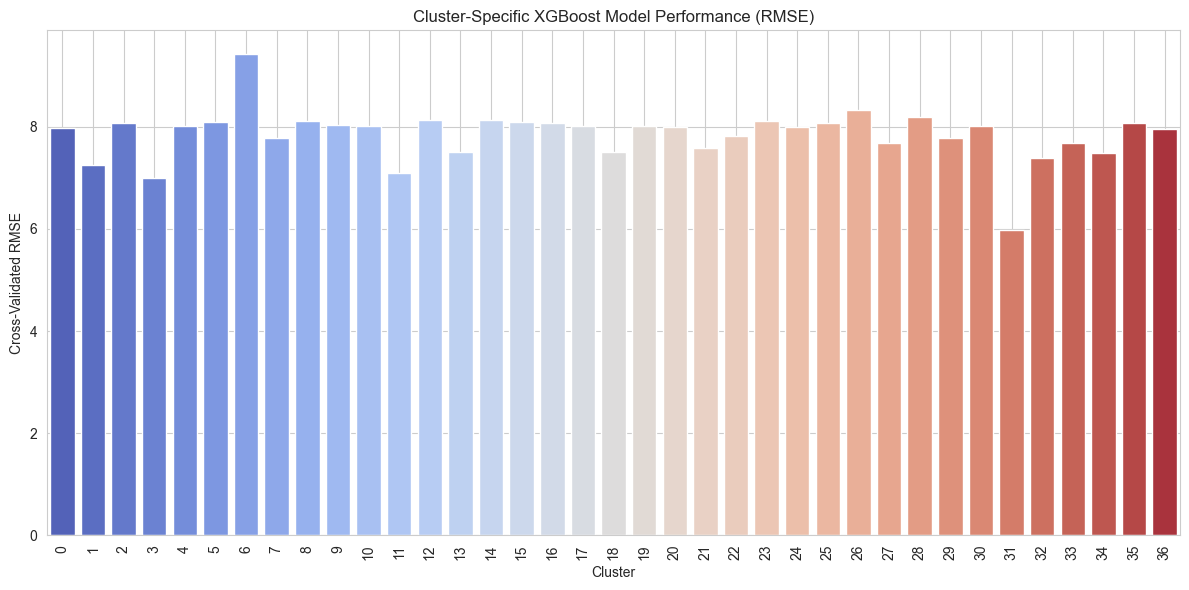

Generating single model predictions for validation donors...


Processing validation donors: 100%|██████████| 14/14 [00:00<00:00, 71.48it/s]

Selected top 4 clusters with best prediction performance
Top clusters: [1, 33, 5, 36]



/var/folders/yk/2j5cfqyd7kj0kyn2bcjzg4lr0000gn/T/ipykernel_1626/3150857981.py:246: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(top_clusters))


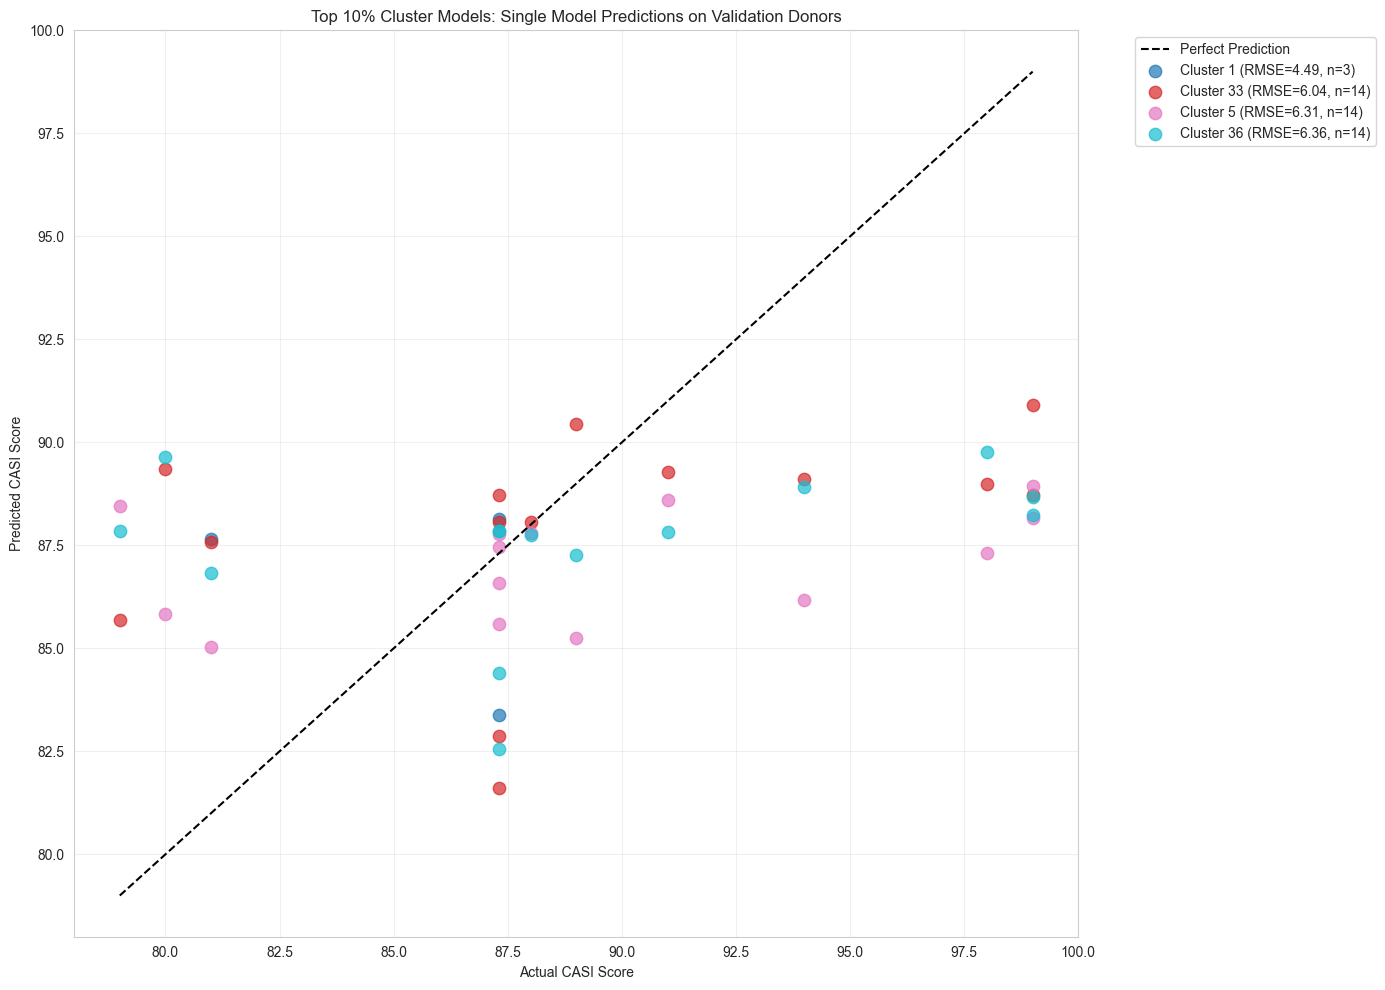

/var/folders/yk/2j5cfqyd7kj0kyn2bcjzg4lr0000gn/T/ipykernel_1626/3150857981.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


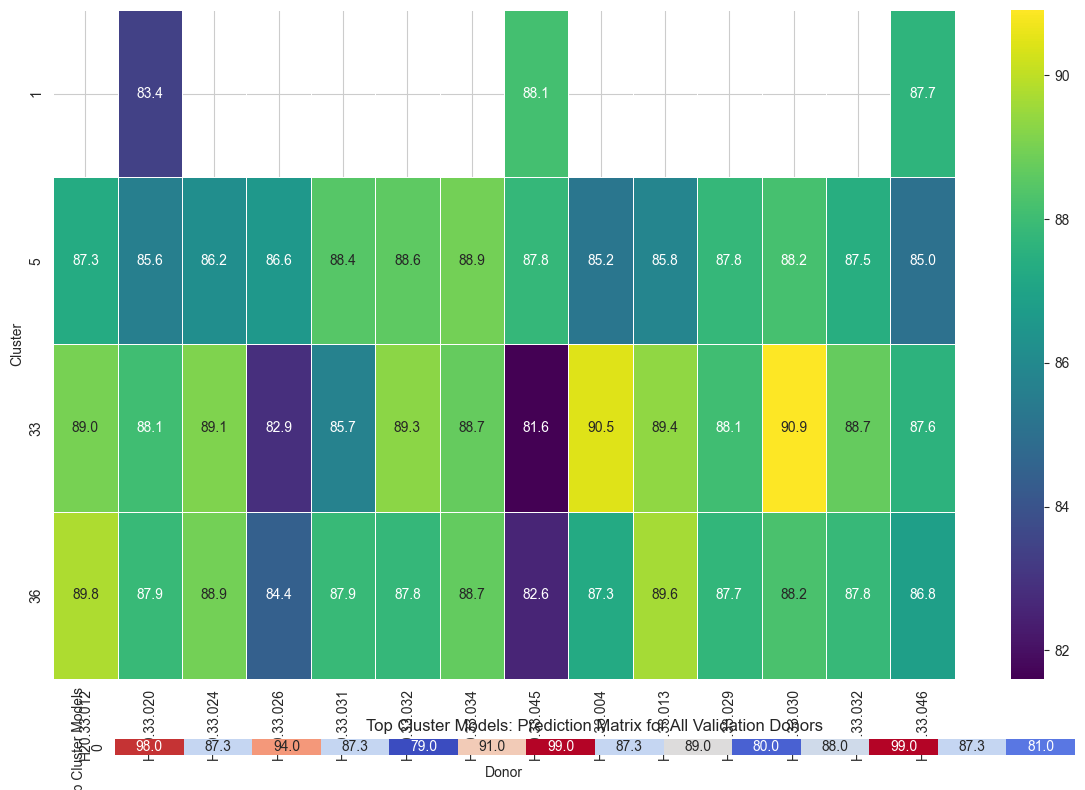

Generating single model predictions for test donors...


Processing test donors: 100%|██████████| 18/18 [00:00<00:00, 72.08it/s]


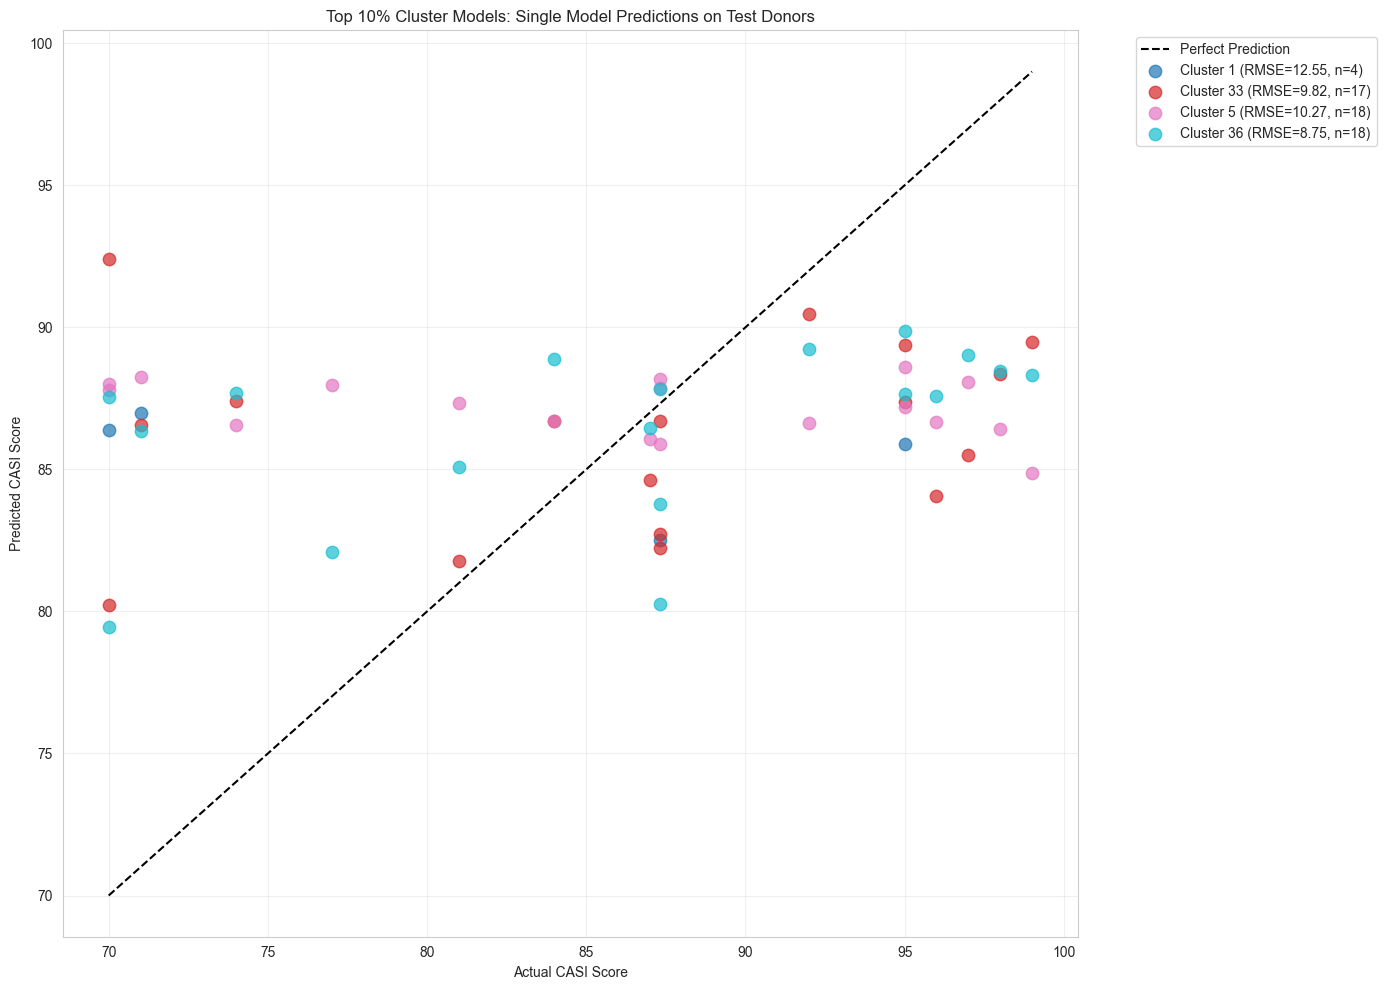

/var/folders/yk/2j5cfqyd7kj0kyn2bcjzg4lr0000gn/T/ipykernel_1626/3150857981.py:439: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


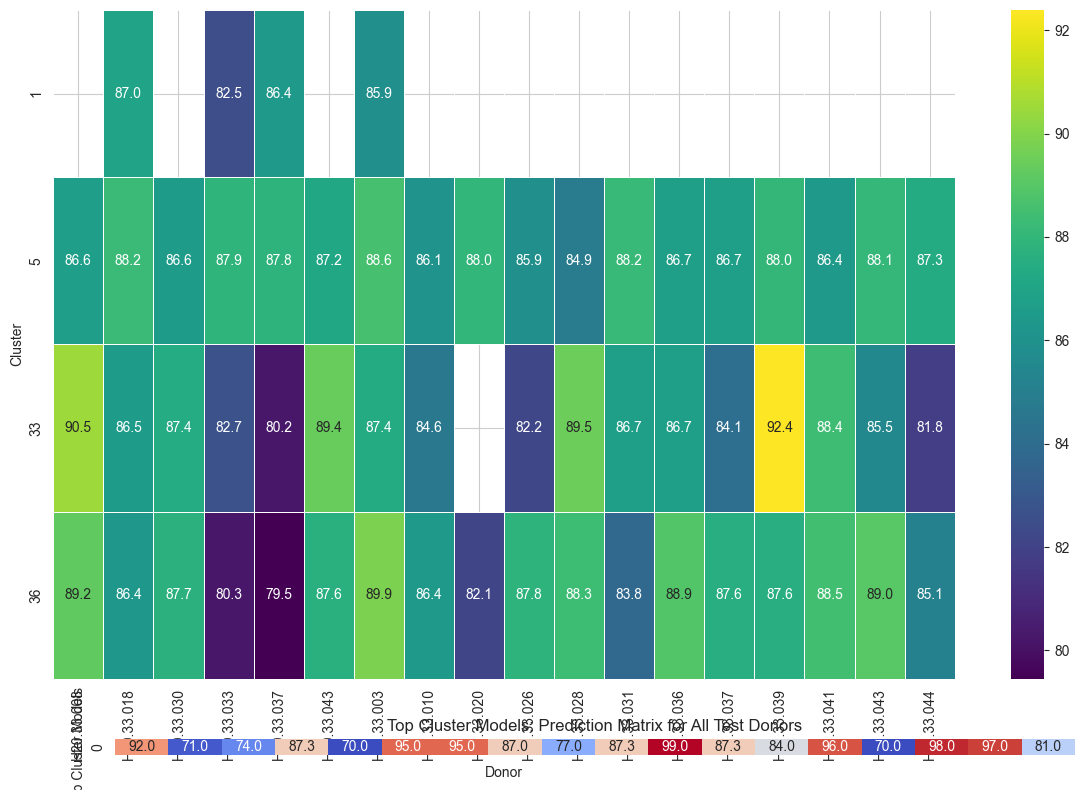

Single model predictions analysis complete. Results saved to 'single_model_predictions.pkl'


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import math

# Initialize dictionaries
models = {}
rmse_scores = {}
model_coefficients = {}

# Print dataset information
print(f"Total donors: {len(unique_donors)}")
print(f"Training donors: {len(train_donors)}")
print(f"Validation donors: {len(valid_donors)}")
print(f"Test donors: {len(test_donors)}")
print(f"Total clusters: {len(unique_clusters)}")

# Train XGBoost model for each cluster
for k in tqdm(unique_clusters, desc="Training XGBoost models"):
    cluster_data = train_df[train_df['cluster'] == k]
    
    # Only train models for clusters with sufficient samples
    if cluster_data.shape[0] >= 10:  # Minimum sample threshold
        # Extract feature vectors from mean_expression
        X = np.stack(cluster_data['mean_expression'].values)
        y = cluster_data['CASI'].values
        
        # Get feature dimension for reporting
        feature_dim = X.shape[1]
        
        # Standardization (optional for XGBoost but can help with some datasets)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Define XGBoost parameters with conservative settings for small datasets
        xgb_params = {
            'max_depth': [2, 3],
            'learning_rate': [0.01, 0.05, 0.1],
            'n_estimators': [50, 100],
            'subsample': [0.6, 0.8],
            'colsample_bytree': [0.6, 0.8],
            'min_child_weight': [1, 3],
            'reg_alpha': [0, 0.1, 1.0],
            'reg_lambda': [0.1, 1.0]
        }
        
        # Create XGBoost regressor
        xgb_model = xgb.XGBRegressor(
            objective='reg:squarederror',
            random_state=42
        )
        
        # Use fewer folds for smaller datasets
        n_folds = min(5, cluster_data.shape[0])
        # If too few samples, use a simpler grid
        if cluster_data.shape[0] < 40:
            xgb_params = {
                'max_depth': [2],
                'learning_rate': [0.05],
                'n_estimators': [50],
                'subsample': [0.8],
                'colsample_bytree': [0.8]
            }
        
        try:
            # Grid search with cross-validation to find best parameters
            if cluster_data.shape[0] >= 3*len(xgb_params):  # Only use GridSearchCV if enough samples
                grid_search = GridSearchCV(
                    estimator=xgb_model,
                    param_grid=xgb_params,
                    cv=n_folds,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    verbose=0
                )
                grid_search.fit(X_scaled, y)
                best_model = grid_search.best_estimator_
                best_rmse = np.sqrt(-grid_search.best_score_)
                print(f"Cluster {k} - Best params: {grid_search.best_params_}")
            else:
                # For very small clusters, use default params
                xgb_model = xgb.XGBRegressor(
                    objective='reg:squarederror',
                    max_depth=2,
                    learning_rate=0.05,
                    n_estimators=50,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42
                )
                # Use simple cross-validation for RMSE estimation
                kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
                rmse_scores_cv = []
                
                for train_idx, val_idx in kf.split(X_scaled):
                    X_train_cv, X_val_cv = X_scaled[train_idx], X_scaled[val_idx]
                    y_train_cv, y_val_cv = y[train_idx], y[val_idx]
                    
                    xgb_model.fit(X_train_cv, y_train_cv)
                    y_pred_cv = xgb_model.predict(X_val_cv)
                    rmse_cv = np.sqrt(mean_squared_error(y_val_cv, y_pred_cv))
                    rmse_scores_cv.append(rmse_cv)
                
                # Train final model on all data
                xgb_model.fit(X_scaled, y)
                best_model = xgb_model
                best_rmse = np.mean(rmse_scores_cv)
                print(f"Cluster {k} - Simple CV RMSE: {best_rmse:.4f}")
            
            # Store model, scaler, and RMSE
            models[k] = {'model': best_model, 'scaler': scaler}
            rmse_scores[k] = best_rmse
            
            # For XGBoost, store feature importances instead of coefficients
            model_coefficients[k] = best_model.feature_importances_
            
        except Exception as e:
            print(f"Error training model for cluster {k}: {e}")
    else:
        print(f"Skipping Cluster {k}: Not enough samples ({cluster_data.shape[0]} < 10)")

# Convert RMSE scores to DataFrame for visualization
rmse_df = pd.DataFrame.from_dict(rmse_scores, orient='index', columns=['RMSE']).reset_index()
rmse_df.columns = ['Cluster', 'RMSE']

# Visualization: RMSE by cluster
plt.figure(figsize=(12, 6))
sns.barplot(data=rmse_df, x='Cluster', y='RMSE', palette='coolwarm')
plt.xlabel('Cluster')
plt.ylabel('Cross-Validated RMSE')
plt.title('Cluster-Specific XGBoost Model Performance (RMSE)')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.savefig('cluster_rmse.png')
plt.show()

# Create prediction structure for single model predictions
# Dictionary format: {donor_id: {cluster_id: prediction_value}}
validation_predictions = {}
validation_actuals = {}

# Initialize dictionaries
for donor in valid_donors:
    validation_predictions[donor] = {}

# Make predictions for each donor using all cluster models
print("Generating single model predictions for validation donors...")
for donor in tqdm(valid_donors, desc="Processing validation donors"):
    donor_data = valid_df[valid_df['Donor ID'] == donor]
    
    if donor_data.empty:
        continue
    
    # Store actual CASI score
    if not donor_data['CASI'].isnull().all():
        validation_actuals[donor] = donor_data['CASI'].iloc[0]
    
    # Process each cluster model
    for cluster in unique_clusters:
        if cluster in models:
            # Get cells from this cluster for this donor
            donor_cluster_data = donor_data[donor_data['cluster'] == cluster]
            
            if not donor_cluster_data.empty:
                # Extract and average expressions for this cluster
                cell_expressions = np.stack(donor_cluster_data['mean_expression'].values)
                X = np.mean(cell_expressions, axis=0).reshape(1, -1)
                
                # Standardize features using this cluster's scaler
                X_scaled = models[cluster]['scaler'].transform(X)
                
                # Predict using this cluster's model
                pred = models[cluster]['model'].predict(X_scaled)[0]
                
                # Store the prediction
                validation_predictions[donor][cluster] = pred

# Create a DataFrame from the validation predictions for easier analysis
validation_data = []
for donor, cluster_preds in validation_predictions.items():
    actual = validation_actuals.get(donor, np.nan)
    for cluster, pred in cluster_preds.items():
        validation_data.append({
            'Donor': donor,
            'Cluster': cluster,
            'Predicted': pred,
            'Actual': actual
        })

validation_df = pd.DataFrame(validation_data)

# Calculate RMSE for each cluster across all donors
cluster_performance = {}
for cluster in unique_clusters:
    if cluster in models:
        cluster_predictions = validation_df[validation_df['Cluster'] == cluster]
        
        # Filter out rows with missing actuals
        cluster_predictions = cluster_predictions.dropna(subset=['Actual'])
        
        if len(cluster_predictions) >= 3:  # Need at least 3 predictions for reliable metrics
            cluster_rmse = np.sqrt(mean_squared_error(
                cluster_predictions['Actual'], 
                cluster_predictions['Predicted']
            ))
            
            cluster_r2 = r2_score(
                cluster_predictions['Actual'], 
                cluster_predictions['Predicted']
            ) if len(cluster_predictions) > 1 else 0
            
            cluster_performance[cluster] = {
                'rmse': cluster_rmse,
                'r2': cluster_r2,
                'n_samples': len(cluster_predictions)
            }

# Select top 10% of clusters based on prediction performance
performance_df = pd.DataFrame.from_dict(cluster_performance, orient='index')
performance_df = performance_df.sort_values('rmse')

# Calculate number of top clusters to select (10% of total)
num_top_clusters = max(1, math.ceil(0.1 * len(performance_df)))
top_clusters = performance_df.head(num_top_clusters).index.tolist()

print(f"Selected top {num_top_clusters} clusters with best prediction performance")
print(f"Top clusters: {top_clusters}")

# Visualize predictions from the top clusters in a single plot
plt.figure(figsize=(14, 10))

# Plot reference line
min_actual = validation_df['Actual'].min()
max_actual = validation_df['Actual'].max()
plt.plot([min_actual, max_actual], [min_actual, max_actual], 'k--', label='Perfect Prediction')

# Get a color map for the top clusters
cmap = plt.cm.get_cmap('tab10', len(top_clusters))

# Plot predictions from top clusters
for i, cluster in enumerate(top_clusters):
    cluster_data = validation_df[validation_df['Cluster'] == cluster].dropna(subset=['Actual'])
    
    if len(cluster_data) > 0:
        cluster_rmse = cluster_performance[cluster]['rmse']
        cluster_n = cluster_performance[cluster]['n_samples']
        
        plt.scatter(
            cluster_data['Actual'],
            cluster_data['Predicted'],
            label=f'Cluster {cluster} (RMSE={cluster_rmse:.2f}, n={cluster_n})',
            color=cmap(i),
            alpha=0.7,
            s=80
        )

plt.xlabel('Actual CASI Score')
plt.ylabel('Predicted CASI Score')
plt.title('Top 10% Cluster Models: Single Model Predictions on Validation Donors')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('top_clusters_predictions.png', bbox_inches='tight')
plt.show()

# Create a prediction heatmap for top clusters
# Filter validation_df to only include top clusters
top_clusters_df = validation_df[validation_df['Cluster'].isin(top_clusters)]

# Pivot the data for the heatmap
heatmap_df = top_clusters_df.pivot(index='Cluster', columns='Donor', values='Predicted')

# Create the heatmap
plt.figure(figsize=(max(12, len(valid_donors)/3), max(8, len(top_clusters))))
mask = np.isnan(heatmap_df)
ax = sns.heatmap(
    heatmap_df,
    mask=mask,
    cmap='viridis',
    annot=True,
    fmt='.1f',
    linewidths=0.5
)

# Add a color bar for actual CASI scores
if validation_actuals:
    ax2 = plt.axes([0.1, 0.05, 0.8, 0.02])
    actual_data = np.array([[validation_actuals.get(donor, np.nan) for donor in heatmap_df.columns]])
    sns.heatmap(
        actual_data,
        ax=ax2,
        cmap='coolwarm',
        annot=True,
        fmt='.1f',
        cbar=False,
        xticklabels=False
    )
    ax2.set_title('Actual CASI')

plt.ylabel('Top Cluster Models')
plt.title('Top Cluster Models: Prediction Matrix for All Validation Donors')
plt.tight_layout()
plt.savefig('top_clusters_heatmap.png')
plt.show()

# Optional: Repeat for test set if available
test_predictions = {}
test_actuals = {}

if len(test_donors) > 0:
    # Initialize dictionaries
    for donor in test_donors:
        test_predictions[donor] = {}
    
    # Make predictions for each donor using all cluster models
    print("Generating single model predictions for test donors...")
    for donor in tqdm(test_donors, desc="Processing test donors"):
        donor_data = test_df[test_df['Donor ID'] == donor]
        
        if donor_data.empty:
            continue
        
        # Store actual CASI score
        if not donor_data['CASI'].isnull().all():
            test_actuals[donor] = donor_data['CASI'].iloc[0]
        
        # Process each cluster model
        for cluster in unique_clusters:
            if cluster in models:
                # Get cells from this cluster for this donor
                donor_cluster_data = donor_data[donor_data['cluster'] == cluster]
                
                if not donor_cluster_data.empty:
                    # Extract and average expressions for this cluster
                    cell_expressions = np.stack(donor_cluster_data['mean_expression'].values)
                    X = np.mean(cell_expressions, axis=0).reshape(1, -1)
                    
                    # Standardize features using this cluster's scaler
                    X_scaled = models[cluster]['scaler'].transform(X)
                    
                    # Predict using this cluster's model
                    pred = models[cluster]['model'].predict(X_scaled)[0]
                    
                    # Store the prediction
                    test_predictions[donor][cluster] = pred
    
    # Create a DataFrame from the test predictions for easier analysis
    test_data = []
    for donor, cluster_preds in test_predictions.items():
        actual = test_actuals.get(donor, np.nan)
        for cluster, pred in cluster_preds.items():
            test_data.append({
                'Donor': donor,
                'Cluster': cluster,
                'Predicted': pred,
                'Actual': actual
            })
    
    test_df_results = pd.DataFrame(test_data)
    
    # Visualize predictions from the top clusters on test set
    if len(test_data) > 0:
        plt.figure(figsize=(14, 10))
        
        # Plot reference line
        min_actual = test_df_results['Actual'].min()
        max_actual = test_df_results['Actual'].max()
        plt.plot([min_actual, max_actual], [min_actual, max_actual], 'k--', label='Perfect Prediction')
        
        # Plot predictions from top clusters
        for i, cluster in enumerate(top_clusters):
            cluster_data = test_df_results[test_df_results['Cluster'] == cluster].dropna(subset=['Actual'])
            
            if len(cluster_data) > 0:
                # Calculate metrics for this cluster on test data
                cluster_rmse = np.sqrt(mean_squared_error(
                    cluster_data['Actual'], 
                    cluster_data['Predicted']
                ))
                
                plt.scatter(
                    cluster_data['Actual'],
                    cluster_data['Predicted'],
                    label=f'Cluster {cluster} (RMSE={cluster_rmse:.2f}, n={len(cluster_data)})',
                    color=cmap(i),
                    alpha=0.7,
                    s=80
                )
        
        plt.xlabel('Actual CASI Score')
        plt.ylabel('Predicted CASI Score')
        plt.title('Top 10% Cluster Models: Single Model Predictions on Test Donors')
        plt.grid(True, alpha=0.3)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig('test_top_clusters_predictions.png', bbox_inches='tight')
        plt.show()
        
        # Create a prediction heatmap for top clusters on test set
        top_test_df = test_df_results[test_df_results['Cluster'].isin(top_clusters)]
        test_heatmap_df = top_test_df.pivot(index='Cluster', columns='Donor', values='Predicted')
        
        plt.figure(figsize=(max(12, len(test_donors)/3), max(8, len(top_clusters))))
        test_mask = np.isnan(test_heatmap_df)
        ax = sns.heatmap(
            test_heatmap_df,
            mask=test_mask,
            cmap='viridis',
            annot=True,
            fmt='.1f',
            linewidths=0.5
        )
        
        # Add a color bar for actual CASI scores
        if test_actuals:
            ax2 = plt.axes([0.1, 0.05, 0.8, 0.02])
            actual_data = np.array([[test_actuals.get(donor, np.nan) for donor in test_heatmap_df.columns]])
            sns.heatmap(
                actual_data,
                ax=ax2,
                cmap='coolwarm',
                annot=True,
                fmt='.1f',
                cbar=False,
                xticklabels=False
            )
            ax2.set_title('Actual CASI')
        
        plt.ylabel('Top Cluster Models')
        plt.title('Top Cluster Models: Prediction Matrix for All Test Donors')
        plt.tight_layout()
        plt.savefig('test_top_clusters_heatmap.png')
        plt.show()

# Save all prediction data and models
results = {
    'models': models,
    'rmse_scores': rmse_scores,
    'model_coefficients': model_coefficients,
    'validation_predictions': validation_predictions,
    'validation_actuals': validation_actuals,
    'cluster_performance': cluster_performance,
    'top_clusters': top_clusters
}

if len(test_donors) > 0:
    results['test_predictions'] = test_predictions
    results['test_actuals'] = test_actuals

with open('single_model_predictions.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Single model predictions analysis complete. Results saved to 'single_model_predictions.pkl'")

Dynamically chosen RMSE threshold: 8.01
Selected 19 clusters after filtering.
Meta-model training data: 52 samples, 19 features
Meta-model validation data: 14 samples, 19 features

Trying different regression models for meta-model with 19 features and 52 samples...

Training Ridge...
Ridge - Best params: {'alpha': 0.1}
Ridge - Validation R²: -0.10, RMSE: 6.67

Training ElasticNet...
ElasticNet - Best params: {'alpha': 0.1, 'l1_ratio': 0.9}
ElasticNet - Validation R²: -0.18, RMSE: 6.91

Training GradientBoosting...
GradientBoosting - Best params: {'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.8}
GradientBoosting - Validation R²: -0.11, RMSE: 6.71

Training RandomForest...
RandomForest - Best params: {'max_depth': None, 'min_samples_split': 2}
RandomForest - Validation R²: -0.15, RMSE: 6.82

Best model: Ridge (Validation R²: -0.10)
Meta-Model R² (Training): 1.00
Meta-Model R² (Validation): -0.10


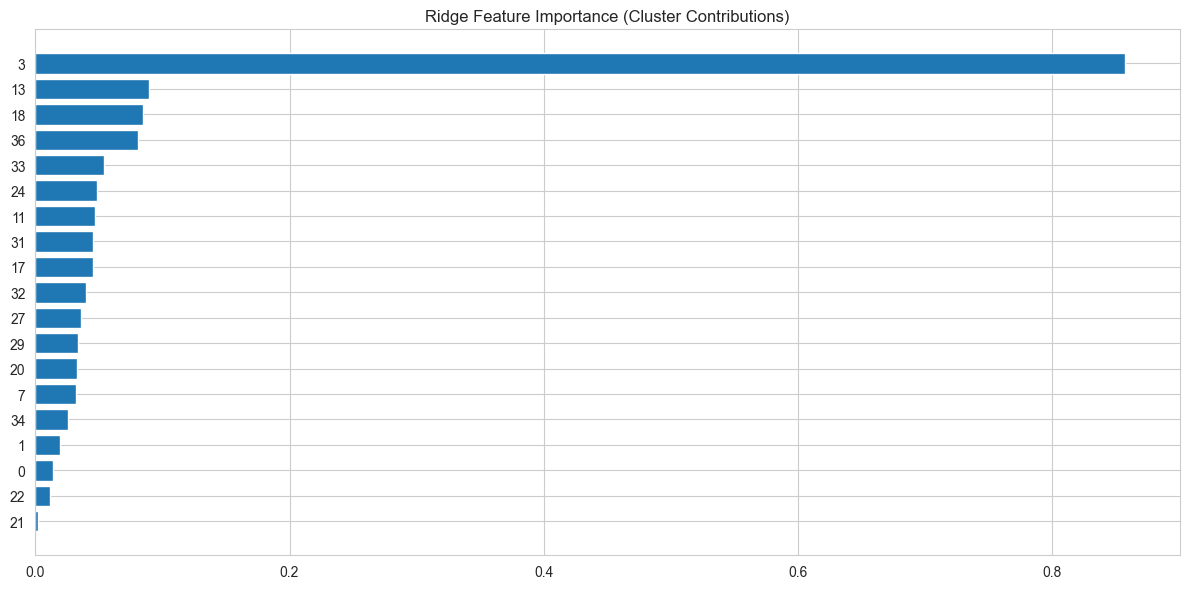

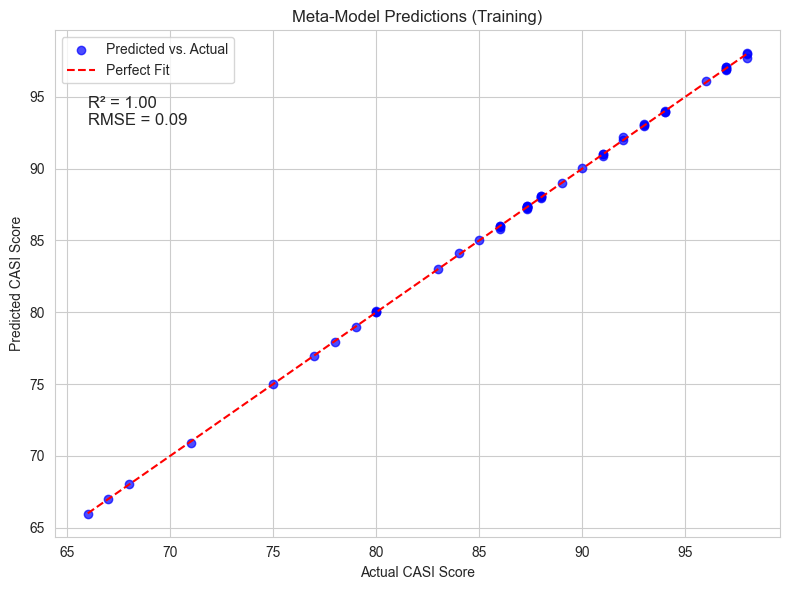

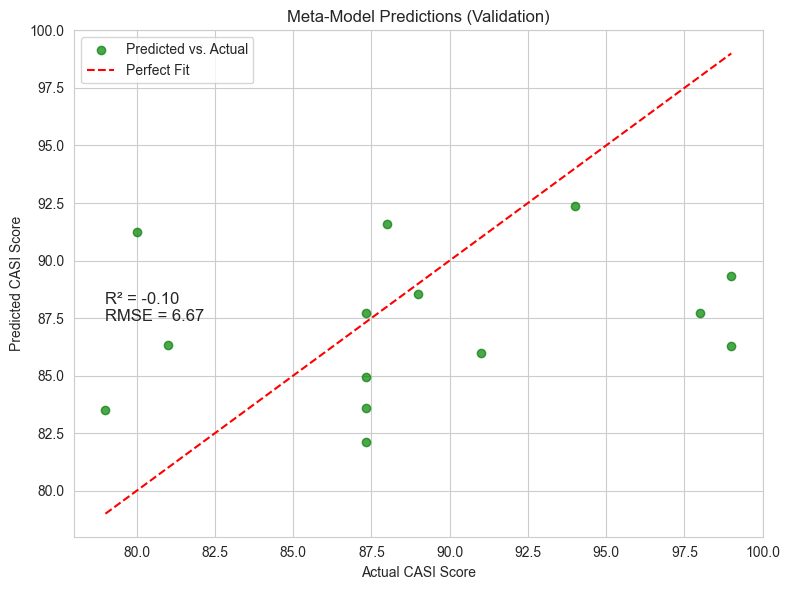


Retraining the best model using combined training and validation data...
Combined dataset for retraining: 66 samples, 19 features
Final model (Ridge) performance on combined training + validation data:
R² = 0.92, RMSE = 2.18

Evaluating on test set...
Test set: 18 donors, 19 features

Meta-Model Test Set Performance (with model retrained on combined data):
R² = -0.24
RMSE = 10.91


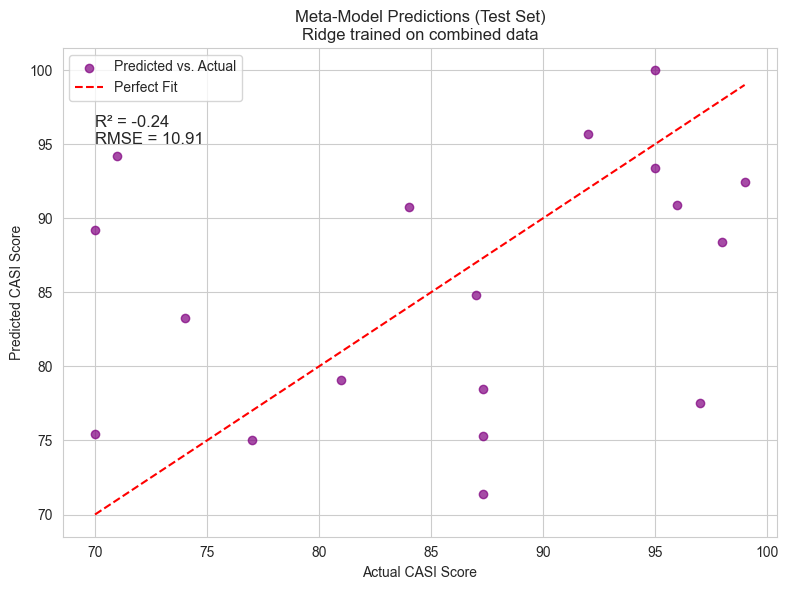


Test set predictions (sorted by error):
      Donor_ID  Actual_CASI  Predicted_CASI  Absolute_Error
3   H20.33.018    71.000000       94.209463       23.209463
15  H21.33.043    97.000000       77.494785       19.505215
9   H21.33.039    70.000000       89.221678       19.221678
11  H20.33.033    87.318841       71.377591       15.941250
0   H21.33.026    87.318841       75.311888       12.006952
17  H21.33.041    98.000000       88.365472        9.634528
13  H20.33.030    74.000000       83.280783        9.280783
6   H21.33.031    87.318841       78.472933        8.845907
16  H21.33.036    84.000000       90.784306        6.784306
12  H21.33.028    99.000000       92.473762        6.526238
Meta-model and results saved to 'meta_model_results.pkl'

Model Comparison:
              Model  Validation R²  Validation RMSE  \
0             Ridge      -0.098888         6.672315   
2  GradientBoosting      -0.112262         6.712795   
3      RandomForest      -0.148156         6.820251   
1  

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.inspection import permutation_importance
import ast

# Assuming models, rmse_df, train_df, valid_df have been created in the previous code
# and patient_cluster_df is the new format dataframe

# Step 1: Compute the percentile RMSE threshold (using 50th percentile)
rmse_threshold = np.percentile(rmse_df['RMSE'], 50)
print(f"Dynamically chosen RMSE threshold: {rmse_threshold:.2f}")

# Step 2: Filter Clusters Based on RMSE
valid_clusters = {k: models[k] for k in rmse_df[rmse_df['RMSE'] <= rmse_threshold]['Cluster'].values}
print(f"Selected {len(valid_clusters)} clusters after filtering.")

# Step 3: Prepare Meta-Model Training Data
X_meta_train, y_meta_train = [], []

for donor in train_donors:
    donor_data = train_df[train_df['Donor ID'] == donor]
    
    if donor_data.empty:
        continue
        
    actual_casi = donor_data['CASI'].iloc[0]
    
    # Initialize predictions dictionary with NaN values
    preds = {k: np.nan for k in valid_clusters.keys()}
    
    # Get predictions for each cluster
    for k in valid_clusters.keys():
        cluster_rows = donor_data[donor_data['cluster'] == k]
        
        if not cluster_rows.empty:
            # Extract feature vectors
            X_k = np.stack(cluster_rows['mean_expression'].values)
            
            # Standardize features
            X_k_scaled = valid_clusters[k]['scaler'].transform(X_k)
            
            # Predict and take mean (if multiple cells in this cluster)
            preds[k] = np.clip(valid_clusters[k]['model'].predict(X_k_scaled).mean(), 0, 100)
    
    # Only include samples with at least one valid prediction
    if any(~np.isnan(list(preds.values()))):
        X_meta_train.append(list(preds.values()))
        y_meta_train.append(actual_casi)

# Handle missing values using KNN imputation
imputer = KNNImputer(n_neighbors=min(3, len(X_meta_train)))
X_train_meta = imputer.fit_transform(X_meta_train)
X_train_meta = pd.DataFrame(X_train_meta, columns=valid_clusters.keys())
y_train_meta = np.array(y_meta_train)

print(f"Meta-model training data: {X_train_meta.shape[0]} samples, {X_train_meta.shape[1]} features")

# Step 4: Prepare Meta-Model Validation Data
X_meta_valid, y_meta_valid = [], []

for donor in valid_donors:
    donor_data = valid_df[valid_df['Donor ID'] == donor]
    
    if donor_data.empty:
        continue
        
    actual_casi = donor_data['CASI'].iloc[0]
    
    # Initialize predictions dictionary with NaN values
    preds = {k: np.nan for k in valid_clusters.keys()}
    
    # Get predictions for each cluster
    for k in valid_clusters.keys():
        cluster_rows = donor_data[donor_data['cluster'] == k]
        
        if not cluster_rows.empty:
            # Extract feature vectors
            X_k = np.stack(cluster_rows['mean_expression'].values)
            
            # Standardize features
            X_k_scaled = valid_clusters[k]['scaler'].transform(X_k)
            
            # Predict and take mean (if multiple cells in this cluster)
            preds[k] = np.clip(valid_clusters[k]['model'].predict(X_k_scaled).mean(), 0, 100)
    
    # Only include samples with at least one valid prediction
    if any(~np.isnan(list(preds.values()))):
        X_meta_valid.append(list(preds.values()))
        y_meta_valid.append(actual_casi)

# Use the same column names as in training
X_valid_meta = imputer.transform(X_meta_valid)  # Use transform (not fit_transform) to use same imputation parameters
X_valid_meta = pd.DataFrame(X_valid_meta, columns=valid_clusters.keys())
y_valid_meta = np.array(y_meta_valid)

print(f"Meta-model validation data: {X_valid_meta.shape[0]} samples, {X_valid_meta.shape[1]} features")

# Step 5: Define multiple regressors to try
regressors = {
    'Ridge': Ridge(random_state=42),
    'ElasticNet': ElasticNet(random_state=42, max_iter=10000),
    'GradientBoosting': GradientBoostingRegressor(random_state=42, n_estimators=100),
    'RandomForest': RandomForestRegressor(random_state=42, n_estimators=100)
}

# Step 6: Define parameter grids for each regressor
param_grids = {
    'Ridge': {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    },
    'ElasticNet': {
        'alpha': [0.01, 0.1, 1.0],
        'l1_ratio': [0.1, 0.5, 0.7, 0.9]
    },
    'GradientBoosting': {
        'max_depth': [2, 3],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8]
    },
    'RandomForest': {
        'max_depth': [None, 3, 5],
        'min_samples_split': [2, 5]
    }
}

# Step 7: Train and select the best regressor using GridSearchCV
best_score = -np.inf
best_model = None
best_model_name = None
results = {}

print(f"\nTrying different regression models for meta-model with {X_train_meta.shape[1]} features and {X_train_meta.shape[0]} samples...")

for name, regressor in regressors.items():
    print(f"\nTraining {name}...")
    grid_search = GridSearchCV(
        estimator=regressor,
        param_grid=param_grids[name],
        cv=min(5, len(X_train_meta)),  # Ensure CV doesn't exceed sample size
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    grid_search.fit(X_train_meta, y_train_meta)
    
    # Get best model
    best_estimator = grid_search.best_estimator_
    
    # Evaluate on validation set
    valid_pred = np.clip(best_estimator.predict(X_valid_meta), 0, 100)
    valid_r2 = r2_score(y_valid_meta, valid_pred)
    valid_rmse = np.sqrt(mean_squared_error(y_valid_meta, valid_pred))
    
    print(f"{name} - Best params: {grid_search.best_params_}")
    print(f"{name} - Validation R²: {valid_r2:.2f}, RMSE: {valid_rmse:.2f}")
    
    results[name] = {
        'model': best_estimator,
        'params': grid_search.best_params_,
        'valid_r2': valid_r2,
        'valid_rmse': valid_rmse
    }
    
    # Track best model
    if valid_r2 > best_score:
        best_score = valid_r2
        best_model = best_estimator
        best_model_name = name

print(f"\nBest model: {best_model_name} (Validation R²: {best_score:.2f})")
bst = best_model

# Step 8: Evaluate Best Model
y_train_pred = np.clip(bst.predict(X_train_meta), 0, 100)
y_valid_pred = np.clip(bst.predict(X_valid_meta), 0, 100)

r2_train = r2_score(y_train_meta, y_train_pred)
r2_valid = r2_score(y_valid_meta, y_valid_pred)

print(f"Meta-Model R² (Training): {r2_train:.2f}")
print(f"Meta-Model R² (Validation): {r2_valid:.2f}")

# Step 9: Feature Importance Analysis
plt.figure(figsize=(12, 6))

# Different feature importance methods based on the selected model
if best_model_name in ['RandomForest', 'GradientBoosting']:
    # For tree-based models, use built-in feature importance
    feature_importances = bst.feature_importances_
    sorted_idx = np.argsort(feature_importances)
    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(X_train_meta.columns)[sorted_idx])
else:
    # For linear models, use coefficient magnitudes
    if hasattr(bst, 'coef_'):
        coeffs = np.abs(bst.coef_)
        sorted_idx = np.argsort(coeffs)
        plt.barh(range(len(sorted_idx)), coeffs[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), np.array(X_train_meta.columns)[sorted_idx])
    else:
        # Fallback to permutation importance
        perm_importance = permutation_importance(bst, X_valid_meta, y_valid_meta, 
                                               n_repeats=10, random_state=42)
        sorted_idx = perm_importance.importances_mean.argsort()
        plt.barh(range(len(sorted_idx)), 
                perm_importance.importances_mean[sorted_idx], 
                align='center')
        plt.yticks(range(len(sorted_idx)), np.array(X_train_meta.columns)[sorted_idx])

plt.title(f'{best_model_name} Feature Importance (Cluster Contributions)')
plt.tight_layout()
plt.savefig('meta_model_feature_importance.png')
plt.show()

# Step 10: Plot Results
def plot_predictions(y_actual, y_pred, title, color):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_pred, alpha=0.7, label="Predicted vs. Actual", color=color)
    plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], 
             color='red', linestyle='--', label="Perfect Fit")
    
    # Calculate R² and RMSE
    r2 = r2_score(y_actual, y_pred)
    rmse = np.sqrt(np.mean((y_actual - y_pred) ** 2))
    
    # Add metrics to the plot
    plt.text(
        min(y_actual), max(y_pred) - 5, 
        f"R² = {r2:.2f}\nRMSE = {rmse:.2f}", 
        fontsize=12
    )
    
    plt.xlabel("Actual CASI Score")
    plt.ylabel("Predicted CASI Score")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    return plt

# Plot and save training results
train_plot = plot_predictions(
    y_train_meta, y_train_pred, 
    "Meta-Model Predictions (Training)", 'blue'
)
train_plot.savefig('meta_model_training_predictions.png')
train_plot.show()

# Plot and save validation results
valid_plot = plot_predictions(
    y_valid_meta, y_valid_pred, 
    "Meta-Model Predictions (Validation)", 'green'
)
valid_plot.savefig('meta_model_validation_predictions.png')
valid_plot.show()

# Step 11: Retrain the best model on combined training and validation data
print("\nRetraining the best model using combined training and validation data...")

# Combine training and validation data
X_combined = pd.concat([X_train_meta, X_valid_meta])
y_combined = np.concatenate([y_train_meta, y_valid_meta])

print(f"Combined dataset for retraining: {X_combined.shape[0]} samples, {X_combined.shape[1]} features")

# Clone the best model with the same hyperparameters
if best_model_name == 'Ridge':
    final_model = Ridge(**bst.get_params())
elif best_model_name == 'ElasticNet':
    final_model = ElasticNet(**bst.get_params())
elif best_model_name == 'GradientBoosting':
    final_model = GradientBoostingRegressor(**bst.get_params())
elif best_model_name == 'RandomForest':
    final_model = RandomForestRegressor(**bst.get_params())
else:
    final_model = bst  # Fallback

# Fit the model on combined data
final_model.fit(X_combined, y_combined)

# Evaluate on the combined data to check for overfitting
y_combined_pred = np.clip(final_model.predict(X_combined), 0, 100)
r2_combined = r2_score(y_combined, y_combined_pred)
rmse_combined = np.sqrt(mean_squared_error(y_combined, y_combined_pred))

print(f"Final model ({best_model_name}) performance on combined training + validation data:")
print(f"R² = {r2_combined:.2f}, RMSE = {rmse_combined:.2f}")

# Step 12: Test Set Evaluation
print("\nEvaluating on test set...")
X_meta_test, y_meta_test = [], []
donor_ids_test = []  # Keep track of donor IDs for later analysis

for donor in test_donors:
    donor_data = test_df[test_df['Donor ID'] == donor]
    
    if donor_data.empty:
        continue
        
    actual_casi = donor_data['CASI'].iloc[0]
    
    # Initialize predictions dictionary with NaN values
    preds = {k: np.nan for k in valid_clusters.keys()}
    
    # Get predictions for each cluster
    for k in valid_clusters.keys():
        cluster_rows = donor_data[donor_data['cluster'] == k]
        
        if not cluster_rows.empty:
            # Extract feature vectors
            X_k = np.stack(cluster_rows['mean_expression'].values)
            
            # Standardize features
            X_k_scaled = valid_clusters[k]['scaler'].transform(X_k)
            
            # Predict and take mean (if multiple cells in this cluster)
            preds[k] = np.clip(valid_clusters[k]['model'].predict(X_k_scaled).mean(), 0, 100)
    
    # Only include samples with at least one valid prediction
    if any(~np.isnan(list(preds.values()))):
        X_meta_test.append(list(preds.values()))
        y_meta_test.append(actual_casi)
        donor_ids_test.append(donor)

# Use the same column names and imputation as in training
X_test_meta = imputer.transform(X_meta_test)
X_test_meta = pd.DataFrame(X_test_meta, columns=valid_clusters.keys())
y_test_meta = np.array(y_meta_test)

print(f"Test set: {X_test_meta.shape[0]} donors, {X_test_meta.shape[1]} features")

# Predict using the final model (trained on combined data)
y_test_pred = np.clip(final_model.predict(X_test_meta), 0, 100)

# Calculate metrics
r2_test = r2_score(y_test_meta, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test_meta, y_test_pred))

print(f"\nMeta-Model Test Set Performance (with model retrained on combined data):")
print(f"R² = {r2_test:.2f}")
print(f"RMSE = {rmse_test:.2f}")

# Plot test results
test_plot = plot_predictions(
    y_test_meta, y_test_pred, 
    f"Meta-Model Predictions (Test Set)\n{best_model_name} trained on combined data", 
    'purple'
)
test_plot.savefig('meta_model_test_predictions.png')
test_plot.show()

# Create DataFrame with predictions for analysis
test_results_df = pd.DataFrame({
    'Donor_ID': donor_ids_test,
    'Actual_CASI': y_test_meta,
    'Predicted_CASI': y_test_pred,
    'Absolute_Error': np.abs(y_test_meta - y_test_pred)
})

# Sort by error to see where the model performs worst
test_results_df = test_results_df.sort_values('Absolute_Error', ascending=False)
print("\nTest set predictions (sorted by error):")
print(test_results_df.head(10))

# Save meta-model and results
import pickle
with open('meta_model_results.pkl', 'wb') as f:
    pickle.dump({
        'meta_model': final_model,  # The model retrained on combined data
        'meta_model_cv': bst,       # The model from cross-validation
        'meta_model_type': best_model_name,
        'all_models_results': results,
        'valid_clusters': valid_clusters,
        'imputer': imputer,
        'performance': {
            'r2_train': r2_train,
            'r2_valid': r2_valid,
            'r2_combined': r2_combined,
            'rmse_combined': rmse_combined,
            'r2_test': r2_test,
            'rmse_test': rmse_test
        },
        'test_predictions': {
            'donor_ids': donor_ids_test,
            'actual': y_test_meta.tolist(),
            'predicted': y_test_pred.tolist()
        },
        'test_results_df': test_results_df
    }, f)

print("Meta-model and results saved to 'meta_model_results.pkl'")

# Create a comparison table of all models
model_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Validation R²': [results[m]['valid_r2'] for m in results],
    'Validation RMSE': [results[m]['valid_rmse'] for m in results],
    'Best Parameters': [str(results[m]['params']) for m in results]
})

print("\nModel Comparison:")
print(model_comparison.sort_values('Validation R²', ascending=False))